# Turning-Points Massive Label Grid + Small Model Grid

This notebook is intentionally focused on turning-point labeling only.

- No Gaussian label tuning.
- No horizon grid search.
- Large search over turning-label parameters and target-frame parameters.
- Small on-the-fly model hyperparameter grid inside each labeling combo.

Primary objective: maximize `profit_y_obj` (movement/profit along Y axis in predicted direction, with extra weight on strong moves).

Also logged on every eval: `profit_y` raw, `recall_up/down/gap` on VAL and TEST, current best objective, and ETA.


In [1]:
from __future__ import annotations

import io
import sys
import time
import itertools
import contextlib
from pathlib import Path
from typing import Any, Dict, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_sample_weight

PROJECT_ROOT = Path.cwd().resolve()
if not (PROJECT_ROOT / "RESEARCH").exists():
    for parent in PROJECT_ROOT.parents:
        if (parent / "RESEARCH").exists():
            PROJECT_ROOT = parent
            break

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from RESEARCH.config import cfg as project_cfg
from RESEARCH.data_loader import load_market_data
from RESEARCH.model_training import check_cuda_available
from src.models.xgb import XGBBaseline

from RESEARCH2.Moon_cycles.turning_points import TurningPointLabelConfig, label_turning_points
from RESEARCH2.Moon_cycles.turning_targets import build_turning_target_frame, merge_features_with_turning_target
from RESEARCH2.Moon_cycles.turning_astro_features import TurningAstroFeatureConfig, build_turning_astro_feature_set
from RESEARCH2.Moon_cycles.eval_utils import compute_binary_metrics
from RESEARCH2.Moon_cycles.splits import make_classic_split

pd.set_option("display.max_columns", None)
pd.set_option("display.expand_frame_repr", False)

print(f"Python: {sys.version.split()[0]}")
print(f"PROJECT_ROOT: {PROJECT_ROOT}")


Python: 3.13.11
PROJECT_ROOT: /home/rut/ostrofun


In [2]:
# =========================
# Search Configuration
# =========================

DATA_START = "2017-11-01"
RUN_TAG = "turning_massive_label_grid"
SEED = 42

# Fixed (NOT searched):
# User explicitly asked to avoid horizon search.
HORIZON_DAYS_FIXED = 10
TAIL_DIRECTION_MODE_FIXED = "endpoint_sign"
TAIL_MIN_MOVE_PCT_FIXED = 0.0

# BIG labeling grid (turning points only)
TURNING_LABEL_GRID = {
    "up_move_pct": [0.025, 0.030, 0.035, 0.040, 0.045],
    "down_move_pct": [0.025, 0.030, 0.035, 0.040, 0.045],
    "cluster_gap_days": [2, 3, 5, 7],
    "min_turn_gap_days": [4, 6, 8, 10],
    "past_horizon_days": [7, 10, 13, 16],
    "past_up_move_pct": [0.06, 0.08, 0.10, 0.12],
    "past_down_move_pct": [0.06, 0.08, 0.10, 0.12],
}

# BIG target-frame grid (dense supervision around turns)
TARGET_FRAME_GRID = {
    "mode": ["window_kernel", "segment_midpoint"],
    "window_radius_days": [6, 8, 10, 12],
    "window_distance_power": [1.2, 1.5, 1.8, 2.1],
    "segment_center_power": [1.2, 1.5, 1.8, 2.1],
    "segment_direction_anchor": ["current_turn"],
    "include_last_open_segment": [True],
    "segment_open_tail_direction_mode": ["last_turn", "endpoint_sign"],
    "segment_open_tail_min_move_pct": [0.0, 0.005, 0.01],
    "min_weight": [0.03, 0.05, 0.08],
    "use_amplitude_weight": [True],
}

# Small model grid (on-the-fly per label combo)
MODEL_GRID = {
    "n_estimators": [300, 500],
    "max_depth": [4, 6],
    "learning_rate": [0.03, 0.05],
    "subsample": [0.8],
    "colsample_bytree": [0.8],
    "early_stopping_rounds": [50],
}

# Astro feature config (fixed during this search)
BIRTH_DT_UTC = str(project_cfg.subject.get("birth_dt_utc", "2009-10-10T18:15:05Z"))
ASTRO_CFG = TurningAstroFeatureConfig(
    coord_mode="both",
    orb_mult=0.10,
    include_pair_aspects=True,
    include_phases=True,
    include_transit_aspects=True,
    add_trig_for_longitudes=True,
    add_trig_for_moon_phase=True,
    add_trig_for_elongations=True,
)

# Objective settings.
# Primary objective is PROFIT along Y axis in predicted direction.
MOVE_WEIGHT_POWER = 1.5
MOVE_WEIGHT_CLIP_Q = 0.98
TOP_MOVE_Q = 0.80

# Threshold tuning penalties (set to 0.0 for pure profit objective).
THRESH_GAP_PENALTY = 0.0
THRESH_PRIOR_PENALTY = 0.0
THRESH_GRID = np.linspace(0.05, 0.95, 91)

# Anti-collapse constraints for class balance.
# Profit remains primary, but only among models that keep recalls balanced.
VAL_RECALL_MIN_FLOOR = 0.35
VAL_RECALL_GAP_CEIL = 0.55
TEST_RECALL_MIN_FLOOR = 0.35
TEST_RECALL_GAP_CEIL = 0.55
THRESH_CONSTRAINT_PENALTY = 2.0
MODEL_CONSTRAINT_PENALTY = 2.0

# Runtime controls
SHUFFLE_LABEL_COMBOS = True
MIN_DATASET_ROWS = 250
RESUME_FROM_CHECKPOINT = True
LOG_EVERY_EVAL = True
LOG_PAIR_START = True
CHECKPOINT_EVERY = 20

# Pair-search acceleration strategy:
# - "auto": choose full only for sane search sizes, else use stratified budget
# - "full": exhaustive cartesian over all label-target pairs (very slow)
# - "random_budget": uniform random sample of pairs
# - "label_stratified_budget": sample labels, then random targets per label (cache friendly)
PAIR_SEARCH_STRATEGY = "auto"
PAIR_BUDGET = 1200
LABEL_BUDGET = 120
TARGETS_PER_LABEL = 10
MAX_FULL_MODEL_EVALS_FOR_AUTO = 250_000
ALLOW_INSANE_FULL_GRID = False

# Model-search acceleration:
# limit number of model combos per pair (None means full MODEL_GRID).
MODEL_BUDGET_PER_PAIR = None

# Pair dataset cache: usually not needed for unique sampled pairs.
USE_PAIR_DATASET_CACHE = False

# Hard cap on model fits in current run.
# Keep this finite, otherwise ETA may be impractical for huge grids.
MAX_TOTAL_MODEL_EVALS = 10000

# Legacy optional cap (mainly for full mode).
MAX_LABEL_COMBOS = None

# Optional fast sanity mode
TEST_MODE = False
if TEST_MODE:
    TURNING_LABEL_GRID = {
        "up_move_pct": [0.035, 0.040],
        "down_move_pct": [0.035],
        "cluster_gap_days": [5],
        "min_turn_gap_days": [8],
        "past_horizon_days": [13],
        "past_up_move_pct": [0.09],
        "past_down_move_pct": [0.09],
    }
    TARGET_FRAME_GRID = {
        "mode": ["segment_midpoint"],
        "window_radius_days": [8],
        "window_distance_power": [1.5],
        "segment_center_power": [1.6],
        "segment_direction_anchor": ["current_turn"],
        "include_last_open_segment": [True],
        "segment_open_tail_direction_mode": ["endpoint_sign"],
        "segment_open_tail_min_move_pct": [0.0],
        "min_weight": [0.05],
        "use_amplitude_weight": [True],
    }
    MODEL_GRID = {
        "n_estimators": [300],
        "max_depth": [4],
        "learning_rate": [0.03],
        "subsample": [0.8],
        "colsample_bytree": [0.8],
        "early_stopping_rounds": [50],
    }
    PAIR_SEARCH_STRATEGY = "label_stratified_budget"
    PAIR_BUDGET = 200
    LABEL_BUDGET = 40
    TARGETS_PER_LABEL = 5
    MODEL_BUDGET_PER_PAIR = None
    USE_PAIR_DATASET_CACHE = False
    MAX_TOTAL_MODEL_EVALS = 800

print("Configured. TEST_MODE=", TEST_MODE)


Configured. TEST_MODE= False


In [3]:
def generate_grid(grid: Dict[str, List[Any]]) -> List[Dict[str, Any]]:
    keys = list(grid.keys())
    vals = [grid[k] for k in keys]
    return [dict(zip(keys, row)) for row in itertools.product(*vals)]


def label_signature(label_cfg: Dict[str, Any]) -> str:
    return str(tuple(sorted(label_cfg.items())))


def target_signature(target_cfg: Dict[str, Any]) -> str:
    return str(tuple(sorted(target_cfg.items())))


def pair_signature(label_cfg: Dict[str, Any], target_cfg: Dict[str, Any]) -> str:
    return str((tuple(sorted(label_cfg.items())), tuple(sorted(target_cfg.items()))))


def make_turning_cfg(label_cfg: Dict[str, Any]) -> TurningPointLabelConfig:
    return TurningPointLabelConfig(
        horizon_days=int(HORIZON_DAYS_FIXED),
        up_move_pct=float(label_cfg["up_move_pct"]),
        down_move_pct=float(label_cfg["down_move_pct"]),
        cluster_gap_days=int(label_cfg["cluster_gap_days"]),
        min_turn_gap_days=int(label_cfg["min_turn_gap_days"]),
        past_horizon_days=int(label_cfg["past_horizon_days"]),
        past_up_move_pct=float(label_cfg["past_up_move_pct"]),
        past_down_move_pct=float(label_cfg["past_down_move_pct"]),
        tail_direction_mode=str(TAIL_DIRECTION_MODE_FIXED),
        tail_min_move_pct=float(TAIL_MIN_MOVE_PCT_FIXED),
    )


def build_turning_points_from_label(df_market: pd.DataFrame, label_cfg: Dict[str, Any]) -> pd.DataFrame:
    turn_cfg = make_turning_cfg(label_cfg)
    _, df_turns, _ = label_turning_points(df_market=df_market, cfg=turn_cfg)
    return df_turns


def build_target_from_turns(df_market: pd.DataFrame, df_turns: pd.DataFrame, target_cfg: Dict[str, Any]) -> tuple[pd.DataFrame, Dict[str, Any]]:
    mode = str(target_cfg["mode"])
    if mode == "window_kernel":
        df_target = build_turning_target_frame(
            df_market=df_market,
            df_turning_points=df_turns,
            mode=mode,
            window_radius_days=int(target_cfg["window_radius_days"]),
            window_distance_power=float(target_cfg["window_distance_power"]),
            min_weight=float(target_cfg["min_weight"]),
            use_amplitude_weight=bool(target_cfg["use_amplitude_weight"]),
            use_numba=True,
        )
    else:
        df_target = build_turning_target_frame(
            df_market=df_market,
            df_turning_points=df_turns,
            mode=mode,
            segment_center_power=float(target_cfg["segment_center_power"]),
            segment_direction_anchor=str(target_cfg["segment_direction_anchor"]),
            include_last_open_segment=bool(target_cfg["include_last_open_segment"]),
            segment_open_tail_direction_mode=str(target_cfg["segment_open_tail_direction_mode"]),
            segment_open_tail_min_move_pct=float(target_cfg["segment_open_tail_min_move_pct"]),
            min_weight=float(target_cfg["min_weight"]),
            use_amplitude_weight=bool(target_cfg["use_amplitude_weight"]),
            use_numba=True,
        )

    meta = {
        "n_turn_points": int(len(df_turns)),
        "n_target_rows": int(len(df_target)),
        "target_mode": mode,
    }
    return df_target, meta


def build_pair_flat_indices(
    n_label: int,
    n_target: int,
    model_combo_count: int,
    rng: np.random.Generator,
) -> tuple[List[int], str]:
    pair_total_full = int(n_label) * int(n_target)
    full_model_evals = int(pair_total_full) * int(model_combo_count)

    strategy_req = str(PAIR_SEARCH_STRATEGY).strip().lower()
    strategy = strategy_req

    if strategy == "auto":
        if full_model_evals <= int(MAX_FULL_MODEL_EVALS_FOR_AUTO):
            strategy = "full"
        else:
            strategy = "label_stratified_budget"

    if strategy == "full" and (not ALLOW_INSANE_FULL_GRID):
        # Safety rail: avoid accidentally launching an impossible full search.
        if full_model_evals > int(MAX_FULL_MODEL_EVALS_FOR_AUTO) * 20:
            print(
                "[SAFETY] full search is too large "
                f"({full_model_evals:,} model evals). Falling back to label_stratified_budget."
            )
            strategy = "label_stratified_budget"

    if strategy == "full":
        flat = np.arange(pair_total_full, dtype=np.int64)
        if SHUFFLE_LABEL_COMBOS:
            rng.shuffle(flat)
        if MAX_LABEL_COMBOS is not None:
            flat = flat[: int(MAX_LABEL_COMBOS)]
        return [int(x) for x in flat.tolist()], strategy

    if strategy == "random_budget":
        sample_n = int(min(max(1, int(PAIR_BUDGET)), pair_total_full))
        flat = rng.choice(pair_total_full, size=sample_n, replace=False).astype(np.int64)
        if SHUFFLE_LABEL_COMBOS:
            rng.shuffle(flat)
        return [int(x) for x in flat.tolist()], strategy

    if strategy == "label_stratified_budget":
        label_take = int(min(max(1, int(LABEL_BUDGET)), n_label))
        target_take = int(min(max(1, int(TARGETS_PER_LABEL)), n_target))

        sampled_labels = rng.choice(n_label, size=label_take, replace=False).astype(np.int64)
        flat_candidates: List[int] = []
        for li in sampled_labels.tolist():
            sampled_targets = rng.choice(n_target, size=target_take, replace=False).astype(np.int64)
            for ti in sampled_targets.tolist():
                flat_candidates.append(int(li * n_target + ti))

        # Deduplicate while preserving order.
        seen = set()
        flat_unique: List[int] = []
        for idx in flat_candidates:
            if idx not in seen:
                seen.add(idx)
                flat_unique.append(idx)

        if PAIR_BUDGET is not None and len(flat_unique) > int(PAIR_BUDGET):
            sampled = rng.choice(np.asarray(flat_unique, dtype=np.int64), size=int(PAIR_BUDGET), replace=False).astype(np.int64)
            flat_unique = [int(x) for x in sampled.tolist()]

        if SHUFFLE_LABEL_COMBOS:
            arr = np.asarray(flat_unique, dtype=np.int64)
            rng.shuffle(arr)
            flat_unique = [int(x) for x in arr.tolist()]

        return flat_unique, strategy

    raise ValueError(
        "PAIR_SEARCH_STRATEGY must be one of: auto, full, random_budget, label_stratified_budget"
    )


def model_indices_for_pair(model_count: int, rng: np.random.Generator) -> List[int]:
    if MODEL_BUDGET_PER_PAIR is None:
        return list(range(int(model_count)))
    take = int(min(max(1, int(MODEL_BUDGET_PER_PAIR)), int(model_count)))
    if take >= int(model_count):
        return list(range(int(model_count)))
    out = rng.choice(int(model_count), size=take, replace=False).astype(np.int64)
    return [int(x) for x in out.tolist()]


def _safe_predict_proba_up(model_obj: XGBBaseline, X: np.ndarray) -> np.ndarray:
    const_cls = getattr(model_obj, "constant_class", None)
    if const_cls is not None:
        c = int(const_cls)
        return np.full(X.shape[0], 1.0 if c == 1 else 0.0, dtype=float)

    Xs = model_obj.scaler.transform(X)

    # Prevent XGBoost warning: booster on CUDA + inference arrays on CPU.
    # We switch booster to CPU for predict_proba and restore afterwards.
    booster = None
    restore_device = None
    try:
        booster = model_obj.model.get_booster()
        restore_device = str(getattr(model_obj, "device", "cpu"))
        booster.set_param({"device": "cpu"})
    except Exception:
        booster = None

    try:
        proba_up = model_obj.model.predict_proba(Xs)[:, 1]
    finally:
        if booster is not None and restore_device and restore_device.startswith("cuda"):
            try:
                booster.set_param({"device": restore_device})
            except Exception:
                pass

    return np.asarray(proba_up, dtype=float)


def weighted_move_vector(next_ret: np.ndarray, sample_weight: np.ndarray, power: float = MOVE_WEIGHT_POWER, clip_q: float = MOVE_WEIGHT_CLIP_Q) -> np.ndarray:
    base = np.abs(np.asarray(next_ret, dtype=float))
    if base.size == 0:
        return np.array([], dtype=float)
    cap = float(np.quantile(base, clip_q))
    if not np.isfinite(cap) or cap <= 0.0:
        cap = float(np.nanmax(base)) if np.isfinite(np.nanmax(base)) and np.nanmax(base) > 0 else 1.0
    move_part = np.clip(base / cap, 0.0, 1.0) ** float(power)
    w = move_part * np.asarray(sample_weight, dtype=float)
    return np.maximum(w, 1e-8)


def move_weighted_acc(y_true: np.ndarray, y_pred: np.ndarray, next_ret: np.ndarray, sample_weight: np.ndarray) -> float:
    w = weighted_move_vector(next_ret=next_ret, sample_weight=sample_weight)
    ok = (np.asarray(y_true, dtype=np.int32) == np.asarray(y_pred, dtype=np.int32)).astype(float)
    return float(np.sum(w * ok) / np.sum(w))


def top_move_acc(y_true: np.ndarray, y_pred: np.ndarray, next_ret: np.ndarray, q: float = TOP_MOVE_Q) -> float:
    mv = np.abs(np.asarray(next_ret, dtype=float))
    if mv.size == 0:
        return 0.0
    thr = float(np.quantile(mv, float(q)))
    mask = mv >= thr
    if int(mask.sum()) == 0:
        return 0.0
    return float((np.asarray(y_true, dtype=np.int32)[mask] == np.asarray(y_pred, dtype=np.int32)[mask]).mean())


def direction_capture(y_pred: np.ndarray, next_ret: np.ndarray, sample_weight: np.ndarray) -> float:
    w = weighted_move_vector(next_ret=next_ret, sample_weight=sample_weight)
    p = np.where(np.asarray(y_pred, dtype=np.int32) == 1, 1.0, -1.0)
    t = np.where(np.asarray(next_ret, dtype=float) >= 0.0, 1.0, -1.0)
    return float(np.sum(w * (p * t)) / np.sum(w))


def profit_y(y_pred: np.ndarray, next_ret: np.ndarray) -> float:
    p = np.where(np.asarray(y_pred, dtype=np.int32) == 1, 1.0, -1.0)
    y = np.asarray(next_ret, dtype=float)
    return float(np.mean(p * y)) if len(y) > 0 else 0.0


def profit_y_obj(y_pred: np.ndarray, next_ret: np.ndarray, sample_weight: np.ndarray) -> float:
    # Main objective: profit along Y direction, with stronger moves weighted higher.
    p = np.where(np.asarray(y_pred, dtype=np.int32) == 1, 1.0, -1.0)
    y = np.asarray(next_ret, dtype=float)
    w = weighted_move_vector(next_ret=y, sample_weight=sample_weight)
    return float(np.sum(w * (p * y)) / np.sum(w))


def tune_threshold_profit(y_val: np.ndarray, proba_val: np.ndarray, next_ret_val: np.ndarray, sample_weight_val: np.ndarray) -> tuple[float, float, float, Dict[str, float], float, float, int]:
    y_val = np.asarray(y_val, dtype=np.int32)
    true_up_share = float((y_val == 1).mean()) if len(y_val) > 0 else 0.5

    best_t = 0.5
    best_score = -1e18
    best_profit_obj = -1e18
    best_profit_raw = -1e18
    best_metrics: Dict[str, float] = {}
    best_violation = 1e18
    best_feasible = 0

    for t in THRESH_GRID:
        pred = (proba_val >= t).astype(np.int32)
        m = compute_binary_metrics(y_val, pred)
        pred_up_share = float((pred == 1).mean()) if len(pred) > 0 else 0.5
        prior_gap = abs(pred_up_share - true_up_share)

        cur_profit_obj = profit_y_obj(pred, next_ret_val, sample_weight_val)
        cur_profit_raw = profit_y(pred, next_ret_val)

        recall_min = float(m["recall_min"])
        recall_gap = float(m["recall_gap"])
        violation = max(0.0, float(VAL_RECALL_MIN_FLOOR) - recall_min) + max(0.0, recall_gap - float(VAL_RECALL_GAP_CEIL))
        feasible = int(violation <= 1e-12)

        # Main score: profit objective with hard anti-collapse penalty.
        score = (
            float(cur_profit_obj)
            - float(THRESH_GAP_PENALTY) * recall_gap
            - float(THRESH_PRIOR_PENALTY) * float(prior_gap)
            - float(THRESH_CONSTRAINT_PENALTY) * float(violation)
        )

        if score > best_score:
            best_score = float(score)
            best_t = float(t)
            best_profit_obj = float(cur_profit_obj)
            best_profit_raw = float(cur_profit_raw)
            best_metrics = m
            best_violation = float(violation)
            best_feasible = int(feasible)
        elif np.isclose(score, best_score):
            best_recall_min = float(best_metrics.get("recall_min", -1.0))
            if feasible > best_feasible:
                best_t = float(t)
                best_profit_obj = float(cur_profit_obj)
                best_profit_raw = float(cur_profit_raw)
                best_metrics = m
                best_violation = float(violation)
                best_feasible = int(feasible)
            elif feasible == best_feasible and float(violation) < float(best_violation):
                best_t = float(t)
                best_profit_obj = float(cur_profit_obj)
                best_profit_raw = float(cur_profit_raw)
                best_metrics = m
                best_violation = float(violation)
                best_feasible = int(feasible)
            elif feasible == best_feasible and np.isclose(float(violation), float(best_violation)) and recall_min > best_recall_min:
                best_t = float(t)
                best_profit_obj = float(cur_profit_obj)
                best_profit_raw = float(cur_profit_raw)
                best_metrics = m
                best_violation = float(violation)
                best_feasible = int(feasible)

    return best_t, best_score, best_profit_obj, best_metrics, best_profit_raw, best_violation, best_feasible


def format_seconds(sec: float) -> str:
    if not np.isfinite(sec) or sec < 0:
        return "na"
    sec_i = int(round(sec))
    h = sec_i // 3600
    m = (sec_i % 3600) // 60
    s = sec_i % 60
    return f"{h:02d}:{m:02d}:{s:02d}"


def sort_results_frame(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return df

    out = df.copy()
    defaults = {
        "is_feasible": 0,
        "total_constraint_violation": 1e9,
        "test_profit_y_obj": -1e9,
        "test_profit_y": -1e9,
        "test_recall_min": -1.0,
        "test_recall_gap": 1e9,
        "mcc": -1e9,
    }
    for k, v in defaults.items():
        if k not in out.columns:
            out[k] = v

    return out.sort_values(
        [
            "is_feasible",
            "total_constraint_violation",
            "test_profit_y_obj",
            "test_profit_y",
            "test_recall_min",
            "test_recall_gap",
            "mcc",
        ],
        ascending=[False, True, False, False, False, True, False],
    )


def is_better(candidate: Dict[str, Any], current: Dict[str, Any]) -> bool:
    if candidate is None:
        return False
    if current is None:
        return True

    cand_feasible = int(candidate.get("is_feasible", 0))
    curr_feasible = int(current.get("is_feasible", 0))
    if cand_feasible != curr_feasible:
        return cand_feasible > curr_feasible

    cand_violation = float(candidate.get("total_constraint_violation", np.inf))
    curr_violation = float(current.get("total_constraint_violation", np.inf))
    if not np.isclose(cand_violation, curr_violation):
        return cand_violation < curr_violation

    c1 = float(candidate.get("test_profit_y_obj", np.nan))
    c2 = float(current.get("test_profit_y_obj", np.nan))

    if np.isnan(c1):
        return False
    if np.isnan(c2):
        return True
    if c1 > c2:
        return True

    r1 = float(candidate.get("test_recall_min", -1.0))
    r2 = float(current.get("test_recall_min", -1.0))
    if not np.isclose(r1, r2):
        return r1 > r2

    g1 = float(candidate.get("test_recall_gap", 1e9))
    g2 = float(current.get("test_recall_gap", 1e9))
    if not np.isclose(g1, g2):
        return g1 < g2

    return float(candidate.get("mcc", -1.0)) > float(current.get("mcc", -1.0))


In [4]:
rng = np.random.default_rng(SEED)

print("=" * 90)
print("TURNING GRID SEARCH V3 | PRIMARY=test_profit_y_obj | VERBOSE_EVAL_LOGS=ON")
print(f"RUN_TAG={RUN_TAG} | LOG_EVERY_EVAL={LOG_EVERY_EVAL} | RESUME_FROM_CHECKPOINT={RESUME_FROM_CHECKPOINT}")
print("Expected per-eval logs: VAL/TEST recall_up/down/gap + profitY + best_so_far + speed + ETA")
print("=" * 90)

label_cfg_combos = generate_grid(TURNING_LABEL_GRID)
target_cfg_combos = generate_grid(TARGET_FRAME_GRID)
model_combos = generate_grid(MODEL_GRID)

# Keep only mode-relevant target params and deduplicate configs.
def _canonical_target_cfg(raw: Dict[str, Any]) -> Dict[str, Any]:
    mode = str(raw["mode"])
    base = {
        "mode": mode,
        "min_weight": float(raw["min_weight"]),
        "use_amplitude_weight": bool(raw["use_amplitude_weight"]),
    }
    if mode == "window_kernel":
        base.update(
            {
                "window_radius_days": int(raw["window_radius_days"]),
                "window_distance_power": float(raw["window_distance_power"]),
            }
        )
    elif mode == "segment_midpoint":
        base.update(
            {
                "segment_center_power": float(raw["segment_center_power"]),
                "segment_direction_anchor": str(raw["segment_direction_anchor"]),
                "include_last_open_segment": bool(raw["include_last_open_segment"]),
                "segment_open_tail_direction_mode": str(raw["segment_open_tail_direction_mode"]),
                "segment_open_tail_min_move_pct": float(raw["segment_open_tail_min_move_pct"]),
            }
        )
    else:
        raise ValueError(f"Unsupported mode: {mode}")
    return base

_canon = [_canonical_target_cfg(c) for c in target_cfg_combos]
_target_unique: Dict[str, Dict[str, Any]] = {}
for t in _canon:
    _target_unique[target_signature(t)] = t
target_cfg_combos_valid = list(_target_unique.values())

n_label = len(label_cfg_combos)
n_target = len(target_cfg_combos_valid)
pair_total_full = n_label * n_target

model_count_total = len(model_combos)
model_count_per_pair = model_count_total if MODEL_BUDGET_PER_PAIR is None else min(model_count_total, int(MODEL_BUDGET_PER_PAIR))
flat_index_list, pair_strategy_used = build_pair_flat_indices(
    n_label=n_label,
    n_target=n_target,
    model_combo_count=model_count_per_pair,
    rng=rng,
)

pairs_total = len(flat_index_list)

def _pair_from_flat_idx(flat_idx: int) -> tuple[Dict[str, Any], Dict[str, Any]]:
    li = int(flat_idx // n_target)
    ti = int(flat_idx % n_target)
    return label_cfg_combos[li], target_cfg_combos_valid[ti]

plan_model_evals_upper = pairs_total * model_count_per_pair
if MAX_TOTAL_MODEL_EVALS is not None:
    plan_model_evals_upper = min(plan_model_evals_upper, int(MAX_TOTAL_MODEL_EVALS))

print(f"Turning label combos: {n_label}")
print(f"Target frame combos:  {n_target}")
print(f"Full pair space:      {pair_total_full}")
print(f"Pair strategy req:    {PAIR_SEARCH_STRATEGY}")
print(f"Pair strategy used:   {pair_strategy_used}")
print(f"Pairs selected:       {pairs_total}")
print(f"Model combos total:   {model_count_total}")
print(f"Model/pair budget:    {model_count_per_pair}")
print(f"Planned eval upper:   {plan_model_evals_upper}")

# Load market data
_df_market = load_market_data()
_df_market = _df_market[_df_market["date"] >= DATA_START].copy()
_df_market["date"] = pd.to_datetime(_df_market["date"])
_df_market["close"] = pd.to_numeric(_df_market["close"], errors="coerce")
_df_market = _df_market.dropna(subset=["date", "close"]).sort_values("date").drop_duplicates("date").reset_index(drop=True)

# Build one reusable close/next-ret map.
close_map = _df_market[["date", "close"]].copy()
close_map["date"] = pd.to_datetime(close_map["date"])
close_map = close_map.sort_values("date").reset_index(drop=True)
close_map["next_close"] = close_map["close"].shift(-1)
close_map["next_ret"] = close_map["next_close"] / close_map["close"] - 1.0

print(f"Market rows: {len(_df_market)} | {_df_market['date'].min().date()} -> {_df_market['date'].max().date()}")

# Build astro features once
print("Building astro feature set once (fixed feature config)...")
df_features = build_turning_astro_feature_set(
    df_market=_df_market,
    birth_dt_utc=BIRTH_DT_UTC,
    cfg=ASTRO_CFG,
    cache_namespace="research2_turning_grid",
    use_cache=True,
    verbose=True,
    progress=True,
)

# Runtime infra
reports_dir = project_cfg.reports_dir
reports_dir.mkdir(parents=True, exist_ok=True)
checkpoint_path = reports_dir / f"{RUN_TAG}_checkpoint.csv"
done_pairs_path = reports_dir / f"{RUN_TAG}_done_pairs.txt"

turn_cache: Dict[str, pd.DataFrame] = {}
pair_cache: Dict[str, pd.DataFrame] = {}
results: List[Dict[str, Any]] = []
done_pairs = set()
best_global = None

# Resume support with schema guard.
eval_counter = 0
resume_schema_ok = False
if RESUME_FROM_CHECKPOINT and checkpoint_path.exists():
    prev = pd.read_csv(checkpoint_path)
    required_cols = {
        "pair_key",
        "test_profit_y_obj",
        "is_feasible",
        "total_constraint_violation",
        "val_constraint_violation",
        "test_constraint_violation",
    }
    if required_cols.issubset(set(prev.columns)):
        resume_schema_ok = True
        results = prev.to_dict(orient="records")
        done_pairs = set(prev["pair_key"].astype(str).tolist())
        if len(prev) > 0:
            best_global = sort_results_frame(prev).iloc[0].to_dict()
            if "eval_id" in prev.columns:
                eval_counter = int(pd.to_numeric(prev["eval_id"], errors="coerce").fillna(0).max())
        print(f"[RESUME] rows={len(prev)} done_pairs={len(done_pairs)} eval_counter_start={eval_counter} from {checkpoint_path}")
    else:
        missing = sorted(list(required_cols.difference(set(prev.columns))))
        print(f"[RESUME] checkpoint exists but schema is old (missing {missing}); starting fresh")

if RESUME_FROM_CHECKPOINT and resume_schema_ok and done_pairs_path.exists():
    text = done_pairs_path.read_text(encoding="utf-8")
    done_pairs.update([line.strip() for line in text.splitlines() if line.strip()])
    print(f"[RESUME] loaded done-pairs registry: {len(done_pairs)} from {done_pairs_path}")
elif RESUME_FROM_CHECKPOINT and (not resume_schema_ok) and done_pairs_path.exists():
    print(f"[RESUME] ignoring done-pairs registry because checkpoint schema is old: {done_pairs_path}")

pairs_todo_start = 0
for flat_idx in flat_index_list:
    lc, tc = _pair_from_flat_idx(flat_idx)
    if pair_signature(lc, tc) not in done_pairs:
        pairs_todo_start += 1

_, device = check_cuda_available()
print("Model device auto-selected:", device)

started_at = time.time()
run_eval_counter = 0
pair_counter = 0
pair_evaluated_counter = 0

for flat_idx in flat_index_list:
    label_cfg, target_cfg = _pair_from_flat_idx(flat_idx)
    pkey = pair_signature(label_cfg, target_cfg)
    if pkey in done_pairs:
        continue

    if MAX_TOTAL_MODEL_EVALS is not None and run_eval_counter >= int(MAX_TOTAL_MODEL_EVALS):
        break

    pair_counter += 1

    if LOG_PAIR_START:
        print(
            f"[PAIR {pair_counter}/{max(pairs_todo_start,1)}] "
            f"label(up={label_cfg['up_move_pct']:.3f},down={label_cfg['down_move_pct']:.3f},"
            f"cluster={label_cfg['cluster_gap_days']},mingap={label_cfg['min_turn_gap_days']},"
            f"past_h={label_cfg['past_horizon_days']}) "
            f"target(mode={target_cfg['mode']},min_w={target_cfg['min_weight']:.3f})"
        )

    if USE_PAIR_DATASET_CACHE and pkey in pair_cache:
        df_dataset = pair_cache[pkey]
    else:
        lkey = label_signature(label_cfg)

        if lkey not in turn_cache:
            turn_cache[lkey] = build_turning_points_from_label(
                df_market=_df_market,
                label_cfg=label_cfg,
            )

        df_turns = turn_cache[lkey]
        if len(df_turns) == 0:
            done_pairs.add(pkey)
            if LOG_PAIR_START:
                print("  [SKIP] no turning points")
            continue

        df_target, _ = build_target_from_turns(
            df_market=_df_market,
            df_turns=df_turns,
            target_cfg=target_cfg,
        )

        if len(df_target) == 0:
            done_pairs.add(pkey)
            if LOG_PAIR_START:
                print("  [SKIP] empty target frame")
            continue

        # Merge features + targets and attach close for move/profit objective.
        df_dataset = merge_features_with_turning_target(
            df_features=df_features,
            df_target=df_target,
            df_market_close=_df_market[["date", "close"]],
        )

        df_dataset = pd.merge(df_dataset, close_map[["date", "next_ret"]], on="date", how="left")
        df_dataset = df_dataset.dropna(subset=["next_ret", "target", "sample_weight", "close"]).sort_values("date").reset_index(drop=True)

        if USE_PAIR_DATASET_CACHE:
            pair_cache[pkey] = df_dataset

    if len(df_dataset) < MIN_DATASET_ROWS:
        done_pairs.add(pkey)
        if LOG_PAIR_START:
            print(f"  [SKIP] dataset too small: rows={len(df_dataset)} < {MIN_DATASET_ROWS}")
        continue

    split = make_classic_split(df_dataset, train_ratio=0.70, val_ratio=0.15)

    train_df = df_dataset.iloc[split.train_idx].copy().reset_index(drop=True)
    val_df = df_dataset.iloc[split.val_idx].copy().reset_index(drop=True)
    test_df = df_dataset.iloc[split.test_idx].copy().reset_index(drop=True)

    if len(train_df) < 80 or len(val_df) < 20 or len(test_df) < 20:
        done_pairs.add(pkey)
        if LOG_PAIR_START:
            print(
                "  [SKIP] split too small: "
                f"train={len(train_df)} val={len(val_df)} test={len(test_df)}"
            )
        continue

    feature_cols = [
        c for c in df_dataset.columns
        if c not in {
            "date", "target", "close", "next_ret",
            "turning_direction", "sample_weight", "target_mode",
            "event_index", "segment_index",
        }
    ]

    X_train = train_df[feature_cols].to_numpy(dtype=np.float32)
    y_train = train_df["target"].to_numpy(dtype=np.int32)
    X_val = val_df[feature_cols].to_numpy(dtype=np.float32)
    y_val = val_df["target"].to_numpy(dtype=np.int32)
    X_test = test_df[feature_cols].to_numpy(dtype=np.float32)
    y_test = test_df["target"].to_numpy(dtype=np.int32)

    sw_train_base = pd.to_numeric(train_df["sample_weight"], errors="coerce").fillna(1.0).to_numpy(dtype=np.float32)
    sw_val_base = pd.to_numeric(val_df["sample_weight"], errors="coerce").fillna(1.0).to_numpy(dtype=np.float32)
    sw_test_base = pd.to_numeric(test_df["sample_weight"], errors="coerce").fillna(1.0).to_numpy(dtype=np.float32)

    sw_train_class = compute_sample_weight(class_weight="balanced", y=y_train).astype(np.float32)
    sw_val_class = compute_sample_weight(class_weight="balanced", y=y_val).astype(np.float32)
    sw_test_class = compute_sample_weight(class_weight="balanced", y=y_test).astype(np.float32)

    sw_train = sw_train_base * sw_train_class
    sw_val = sw_val_base * sw_val_class
    sw_test = sw_test_base * sw_test_class

    ret_val = pd.to_numeric(val_df["next_ret"], errors="coerce").fillna(0.0).to_numpy(dtype=np.float32)
    ret_test = pd.to_numeric(test_df["next_ret"], errors="coerce").fillna(0.0).to_numpy(dtype=np.float32)

    pair_model_indices = model_indices_for_pair(len(model_combos), rng)

    if LOG_PAIR_START:
        print(
            f"  rows={len(df_dataset)} features={len(feature_cols)} "
            f"turn_pts={len(turn_cache[label_signature(label_cfg)])} "
            f"models={len(pair_model_indices)}/{len(model_combos)}"
        )

    best_local = None

    for model_i, model_idx in enumerate(pair_model_indices, start=1):
        if MAX_TOTAL_MODEL_EVALS is not None and run_eval_counter >= int(MAX_TOTAL_MODEL_EVALS):
            break

        model_cfg = model_combos[int(model_idx)]

        run_eval_counter += 1
        eval_counter += 1

        # Train with fallback to CPU on CUDA errors.
        req_device = str(device)

        def _make_model(device_name: str) -> XGBBaseline:
            return XGBBaseline(
                n_classes=2,
                device=device_name,
                random_state=SEED,
                early_stopping_rounds=int(model_cfg["early_stopping_rounds"]),
                n_estimators=int(model_cfg["n_estimators"]),
                max_depth=int(model_cfg["max_depth"]),
                learning_rate=float(model_cfg["learning_rate"]),
                subsample=float(model_cfg["subsample"]),
                colsample_bytree=float(model_cfg["colsample_bytree"]),
                tree_method="hist",
                eval_metric="logloss",
            )

        model = _make_model(req_device)
        used_device = req_device

        try:
            model.fit(
                X_train=X_train,
                y_train=y_train,
                X_val=X_val,
                y_val=y_val,
                feature_names=feature_cols,
                sample_weight=sw_train,
                sample_weight_val=sw_val,
            )
        except Exception as err:
            if str(req_device).startswith("cuda"):
                model = _make_model("cpu")
                used_device = "cpu"
                model.fit(
                    X_train=X_train,
                    y_train=y_train,
                    X_val=X_val,
                    y_val=y_val,
                    feature_names=feature_cols,
                    sample_weight=sw_train,
                    sample_weight_val=sw_val,
                )
            else:
                print("[WARN] model fit failed:", repr(err))
                continue

        p_val = _safe_predict_proba_up(model, X_val)
        p_test = _safe_predict_proba_up(model, X_test)

        thr, val_score, val_profit_obj, val_metrics, val_profit_raw, val_thr_violation, val_thr_feasible = tune_threshold_profit(
            y_val=y_val,
            proba_val=p_val,
            next_ret_val=ret_val,
            sample_weight_val=sw_val,
        )

        pred_val = (p_val >= thr).astype(np.int32)
        pred_test = (p_test >= thr).astype(np.int32)

        test_metrics = compute_binary_metrics(y_test, pred_test)

        cur_val_profit_y = float(val_profit_raw)
        cur_val_profit_obj = float(val_profit_obj)
        cur_test_profit_y = profit_y(pred_test, ret_test)
        cur_test_profit_obj = profit_y_obj(pred_test, ret_test, sw_test)

        cur_test_move_weighted_acc = move_weighted_acc(y_test, pred_test, ret_test, sw_test)
        cur_test_top_move_acc = top_move_acc(y_test, pred_test, ret_test, q=TOP_MOVE_Q)
        cur_test_direction_capture = direction_capture(pred_test, ret_test, sw_test)

        val_violation = max(0.0, float(VAL_RECALL_MIN_FLOOR) - float(val_metrics["recall_min"])) + max(0.0, float(val_metrics["recall_gap"]) - float(VAL_RECALL_GAP_CEIL))
        test_violation = max(0.0, float(TEST_RECALL_MIN_FLOOR) - float(test_metrics["recall_min"])) + max(0.0, float(test_metrics["recall_gap"]) - float(TEST_RECALL_GAP_CEIL))
        total_violation = float(val_violation + test_violation)
        val_feasible = int(val_violation <= 1e-12)
        test_feasible = int(test_violation <= 1e-12)
        is_feasible = int(val_feasible == 1 and test_feasible == 1)
        selection_score = float(cur_test_profit_obj) - float(MODEL_CONSTRAINT_PENALTY) * float(total_violation)

        row = {
            "pair_key": pkey,
            **{f"label_{k}": v for k, v in label_cfg.items()},
            **{f"target_{k}": v for k, v in target_cfg.items()},
            **{f"model_{k}": v for k, v in model_cfg.items()},
            "horizon_days_fixed": int(HORIZON_DAYS_FIXED),
            "tail_direction_mode_fixed": str(TAIL_DIRECTION_MODE_FIXED),
            "tail_min_move_pct_fixed": float(TAIL_MIN_MOVE_PCT_FIXED),
            "birth_dt_utc": str(BIRTH_DT_UTC),
            "feature_coord_mode": str(ASTRO_CFG.coord_mode),
            "feature_orb_mult": float(ASTRO_CFG.orb_mult),
            "target_rows": int(len(df_dataset)),
            "train_rows": int(len(train_df)),
            "val_rows": int(len(val_df)),
            "test_rows": int(len(test_df)),
            "threshold": float(thr),
            "val_objective": float(val_score),
            "val_threshold_feasible": int(val_thr_feasible),
            "val_threshold_violation": float(val_thr_violation),

            # Constraint diagnostics
            "val_constraint_violation": float(val_violation),
            "test_constraint_violation": float(test_violation),
            "total_constraint_violation": float(total_violation),
            "val_feasible": int(val_feasible),
            "test_feasible": int(test_feasible),
            "is_feasible": int(is_feasible),
            "selection_score": float(selection_score),

            # Primary objective family
            "val_profit_y": float(cur_val_profit_y),
            "val_profit_y_obj": float(cur_val_profit_obj),
            "test_profit_y": float(cur_test_profit_y),
            "test_profit_y_obj": float(cur_test_profit_obj),

            # Secondary movement diagnostics
            "test_move_weighted_acc": float(cur_test_move_weighted_acc),
            "test_top_move_acc": float(cur_test_top_move_acc),
            "test_direction_capture": float(cur_test_direction_capture),

            # Validation recalls requested
            "val_recall_up": float(val_metrics["recall_up"]),
            "val_recall_down": float(val_metrics["recall_down"]),
            "val_recall_gap": float(val_metrics["recall_gap"]),
            "val_recall_min": float(val_metrics["recall_min"]),

            # Test recalls requested
            "test_recall_up": float(test_metrics["recall_up"]),
            "test_recall_down": float(test_metrics["recall_down"]),
            "test_recall_gap": float(test_metrics["recall_gap"]),
            "test_recall_min": float(test_metrics["recall_min"]),

            # Other standard metrics
            "acc": float(test_metrics["accuracy"]),
            "bal_acc": float(test_metrics["balanced_accuracy"]),
            "mcc": float(test_metrics["mcc"]),
            "f1_macro": float(test_metrics["f1_macro"]),

            "device_used": str(used_device),
            "eval_id": int(eval_counter),
            "elapsed_min": float((time.time() - started_at) / 60.0),
        }

        if is_better(row, best_local):
            best_local = row

        if is_better(row, best_global):
            best_global = row
            print(
                "[NEW GLOBAL BEST]",
                f"eval={best_global['eval_id']}",
                f"feasible={int(best_global.get('is_feasible', 0))}",
                f"viol={float(best_global.get('total_constraint_violation', np.nan)):.4f}",
                f"test_profit_y_obj={best_global['test_profit_y_obj']:+.8f}",
                f"test_profit_y={best_global['test_profit_y']:+.8f}",
                f"test_rec_up={best_global['test_recall_up']:.3f}",
                f"test_rec_down={best_global['test_recall_down']:.3f}",
                f"test_rec_gap={best_global['test_recall_gap']:.3f}",
                f"test_rec_min={best_global['test_recall_min']:.3f}",
                f"mcc={best_global['mcc']:.3f}",
                f"bal_acc={best_global['bal_acc']:.3f}",
            )

        if LOG_EVERY_EVAL:
            elapsed_sec = time.time() - started_at
            if run_eval_counter > 0:
                eval_rate = run_eval_counter / max(elapsed_sec, 1e-9)
                sec_per_eval = elapsed_sec / max(run_eval_counter, 1)
                remain_evals = max(plan_model_evals_upper - run_eval_counter, 0)
                eta_sec = remain_evals / max(eval_rate, 1e-9)
            else:
                eval_rate = np.nan
                sec_per_eval = np.nan
                eta_sec = np.nan

            best_obj = float(best_global["test_profit_y_obj"]) if best_global is not None else np.nan
            best_eval = int(best_global["eval_id"]) if best_global is not None and "eval_id" in best_global else -1
            if best_global is not None:
                best_line = (
                    f"BEST_SO_FAR eval={best_eval} feas={int(best_global.get('is_feasible', 0))} "
                    f"viol={float(best_global.get('total_constraint_violation', np.nan)):.4f} "
                    f"profitOBJ={float(best_global.get('test_profit_y_obj', np.nan)):+.8f} "
                    f"profitY={float(best_global.get('test_profit_y', np.nan)):+.8f} "
                    f"val_rmin={float(best_global.get('val_recall_min', np.nan)):.3f} "
                    f"val_gap={float(best_global.get('val_recall_gap', np.nan)):.3f} "
                    f"test_rmin={float(best_global.get('test_recall_min', np.nan)):.3f} "
                    f"test_gap={float(best_global.get('test_recall_gap', np.nan)):.3f} "
                    f"mcc={float(best_global.get('mcc', np.nan)):.3f} "
                    f"bal_acc={float(best_global.get('bal_acc', np.nan)):.3f}"
                )
            else:
                best_line = "BEST_SO_FAR eval=na"

            print(
                f"[EVAL {run_eval_counter}/{plan_model_evals_upper}] "
                f"pair={pair_counter}/{max(pairs_todo_start,1)} "
                f"model={model_i}/{len(pair_model_indices)} "
                f"elapsed={format_seconds(elapsed_sec)} eta~{format_seconds(eta_sec)} "
                f"speed={eval_rate:.3f}/s ({sec_per_eval:.2f}s/eval)"
            )
            print(
                "  CURRENT "
                f"VAL: profitY={cur_val_profit_y:+.8f} profitOBJ={cur_val_profit_obj:+.8f} "
                f"rec_up={row['val_recall_up']:.3f} rec_down={row['val_recall_down']:.3f} gap={row['val_recall_gap']:.3f} "
                f"rmin={row['val_recall_min']:.3f} viol={row['val_constraint_violation']:.3f} | "
                f"TEST: profitY={cur_test_profit_y:+.8f} profitOBJ={cur_test_profit_obj:+.8f} "
                f"rec_up={row['test_recall_up']:.3f} rec_down={row['test_recall_down']:.3f} gap={row['test_recall_gap']:.3f} "
                f"rmin={row['test_recall_min']:.3f} viol={row['test_constraint_violation']:.3f} | "
                f"{best_line}"
            )

    done_pairs.add(pkey)

    if best_local is not None:
        pair_evaluated_counter += 1
        results.append(best_local)

    if pair_counter % CHECKPOINT_EVERY == 0:
        if len(results) > 0:
            df_ckpt = sort_results_frame(pd.DataFrame(results))
            df_ckpt.to_csv(checkpoint_path, index=False)
            done_pairs_path.write_text("\n".join(sorted(done_pairs)), encoding="utf-8")
            print(
                f"[CHECKPOINT] rows={len(df_ckpt)} pairs_done={pair_counter}/{max(pairs_todo_start,1)} "
                f"pairs_with_eval={pair_evaluated_counter} done_pairs_total={len(done_pairs)} path={checkpoint_path}"
            )
        else:
            done_pairs_path.write_text("\n".join(sorted(done_pairs)), encoding="utf-8")
            print(
                f"[CHECKPOINT] no result rows yet, pairs_done={pair_counter}/{max(pairs_todo_start,1)} "
                f"done_pairs_total={len(done_pairs)}"
            )

print(
    f"Finished: run_evals={run_eval_counter}, eval_id_last={eval_counter}, "
    f"pairs_done={pair_counter}/{max(pairs_todo_start,1)}, "
    f"pairs_with_eval={pair_evaluated_counter}, kept_rows={len(results)}"
)

if len(results) > 0:
    df_results = sort_results_frame(pd.DataFrame(results)).reset_index(drop=True)
    df_results.to_csv(checkpoint_path, index=False)
    done_pairs_path.write_text("\n".join(sorted(done_pairs)), encoding="utf-8")
    print(f"Saved final: {checkpoint_path}")
else:
    df_results = pd.DataFrame()
    done_pairs_path.write_text("\n".join(sorted(done_pairs)), encoding="utf-8")
    print("No valid combinations")


TURNING GRID SEARCH V3 | PRIMARY=test_profit_y_obj | VERBOSE_EVAL_LOGS=ON
RUN_TAG=turning_massive_label_grid | LOG_EVERY_EVAL=True | RESUME_FROM_CHECKPOINT=True
Expected per-eval logs: VAL/TEST recall_up/down/gap + profitY + best_so_far + speed + ETA
Turning label combos: 25600
Target frame combos:  120
Full pair space:      3072000
Pair strategy req:    auto
Pair strategy used:   label_stratified_budget
Pairs selected:       1200
Model combos total:   8
Model/pair budget:    8
Planned eval upper:   9600
Loaded 5682 rows from parquet for subject=btc
Date range: 2010-07-18 -> 2026-02-05
Market rows: 3019 | 2017-11-01 -> 2026-02-05
Building astro feature set once (fixed feature config)...
📂 Loading from cache: research2_turning_grid_ephem__ephemeris_features__2017-11-01_both_orb0.1_phases__31e312cb.parquet
📂 Loading from cache: research2_turning_grid_transits__transit_to_natal_features__2017-11-01_orb0.1__2afd366c.parquet
Full turning astro feature set: rows=3019 cols=2670 birth_dt_utc=2

/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 3025/9600] pair=379/1200 model=1/8 elapsed=00:58:39 eta~02:07:28 speed=0.860/s (1.16s/eval)
  CURRENT VAL: profitY=-0.00026949 profitOBJ=-0.00376956 rec_up=0.532 rec_down=0.090 gap=0.441 rmin=0.090 viol=0.260 | TEST: profitY=-0.00024350 profitOBJ=+0.00092405 rec_up=0.956 rec_down=0.000 gap=0.956 rmin=0.000 viol=0.756 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 3026/9600] pair=379/1200 model=2/8 elapsed=00:58:40 eta~02:07:27 speed=0.860/s (1.16s/eval)
  CURRENT VAL: profitY=+0.00000990 profitOBJ=-0.00445731 rec_up=0.448 rec_down=0.181 gap=0.268 rmin=0.181 viol=0.169 | TEST: profitY=+0.00090988 profitOBJ=-0.00365443 rec_up=0.611 rec_down=0.000 gap=0.611 rmin=0.000 viol=0.411 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 3027/9600] pair=379/1200 model=3/8 elapsed=00:58:41 eta~02:07:26 speed=0.860/s (1.16s/eval)
  CURRENT VAL: profitY=-0.00026949 profitOBJ=-0.00376956 rec_up=0.532 rec_down=0.090 gap=0.441 rmin=0.090 viol=0.260 | TEST: profitY=+0.00091904 profitOBJ=+0.00816177 rec_up=0.783 rec_down=0.000 gap=0.783 rmin=0.000 viol=0.583 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 3028/9600] pair=379/1200 model=4/8 elapsed=00:58:42 eta~02:07:25 speed=0.860/s (1.16s/eval)
  CURRENT VAL: profitY=-0.00000963 profitOBJ=-0.00466897 rec_up=0.421 rec_down=0.181 gap=0.240 rmin=0.181 viol=0.169 | TEST: profitY=+0.00153599 profitOBJ=+0.00796012 rec_up=0.626 rec_down=0.000 gap=0.626 rmin=0.000 viol=0.426 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 3029/9600] pair=379/1200 model=5/8 elapsed=00:58:43 eta~02:07:23 speed=0.860/s (1.16s/eval)
  CURRENT VAL: profitY=-0.00026949 profitOBJ=-0.00376956 rec_up=0.532 rec_down=0.090 gap=0.441 rmin=0.090 viol=0.260 | TEST: profitY=-0.00024350 profitOBJ=+0.00092405 rec_up=0.956 rec_down=0.000 gap=0.956 rmin=0.000 viol=0.756 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 3030/9600] pair=379/1200 model=6/8 elapsed=00:58:44 eta~02:07:22 speed=0.860/s (1.16s/eval)
  CURRENT VAL: profitY=+0.00000990 profitOBJ=-0.00445731 rec_up=0.448 rec_down=0.181 gap=0.268 rmin=0.181 viol=0.169 | TEST: profitY=+0.00090988 profitOBJ=-0.00365443 rec_up=0.611 rec_down=0.000 gap=0.611 rmin=0.000 viol=0.411 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 3031/9600] pair=379/1200 model=7/8 elapsed=00:58:46 eta~02:07:21 speed=0.860/s (1.16s/eval)
  CURRENT VAL: profitY=-0.00026949 profitOBJ=-0.00376956 rec_up=0.532 rec_down=0.090 gap=0.441 rmin=0.090 viol=0.260 | TEST: profitY=+0.00091904 profitOBJ=+0.00816177 rec_up=0.783 rec_down=0.000 gap=0.783 rmin=0.000 viol=0.583 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 3032/9600] pair=379/1200 model=8/8 elapsed=00:58:47 eta~02:07:20 speed=0.860/s (1.16s/eval)
  CURRENT VAL: profitY=-0.00000963 profitOBJ=-0.00466897 rec_up=0.421 rec_down=0.181 gap=0.240 rmin=0.181 viol=0.169 | TEST: profitY=+0.00153599 profitOBJ=+0.00796012 rec_up=0.626 rec_down=0.000 gap=0.626 rmin=0.000 viol=0.426 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873
[PAIR 380/1200] label(up=0.040,down=0.030,cluster=5,mingap=6,past_h=16) target(mode=window_kernel,min_w=0.030)
  rows=2080 features=2670 turn_pts=157 models=8/8
[EVAL 3033/9600] pair=380/1200 model=1/8 elapsed=00:58:48 eta~02:07:19 speed=0.860/s (1.16s/eval)
  CURRENT VAL: profitY=+0.00123602 profitOBJ=+0.00599777 rec_up=0.414 rec_down=0.566 gap=0.152 rmin=0.414 viol=0.000 | TEST: profitY=+0.00020749 profitOBJ=-0.00241022 rec_up=0.553 rec_down=0.716 gap=0.163 rmin=0.553 viol=0.000 | BEST_SO_FAR eval=2

/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 3153/9600] pair=395/1200 model=1/8 elapsed=01:01:09 eta~02:05:02 speed=0.859/s (1.16s/eval)
  CURRENT VAL: profitY=-0.00202916 profitOBJ=-0.01056396 rec_up=0.354 rec_down=0.169 gap=0.185 rmin=0.169 viol=0.181 | TEST: profitY=+0.00172237 profitOBJ=+0.00164733 rec_up=0.577 rec_down=0.000 gap=0.577 rmin=0.000 viol=0.377 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 3154/9600] pair=395/1200 model=2/8 elapsed=01:01:10 eta~02:05:01 speed=0.859/s (1.16s/eval)
  CURRENT VAL: profitY=-0.00194920 profitOBJ=-0.01058424 rec_up=0.354 rec_down=0.250 gap=0.104 rmin=0.250 viol=0.100 | TEST: profitY=+0.00147966 profitOBJ=+0.00054526 rec_up=0.511 rec_down=0.000 gap=0.511 rmin=0.000 viol=0.350 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 3155/9600] pair=395/1200 model=3/8 elapsed=01:01:11 eta~02:05:00 speed=0.859/s (1.16s/eval)
  CURRENT VAL: profitY=-0.00194920 profitOBJ=-0.01058424 rec_up=0.354 rec_down=0.250 gap=0.104 rmin=0.250 viol=0.100 | TEST: profitY=+0.00117491 profitOBJ=+0.00003839 rec_up=0.546 rec_down=0.000 gap=0.546 rmin=0.000 viol=0.350 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 3156/9600] pair=395/1200 model=4/8 elapsed=01:01:13 eta~02:04:59 speed=0.859/s (1.16s/eval)
  CURRENT VAL: profitY=-0.00181741 profitOBJ=-0.01100145 rec_up=0.326 rec_down=0.369 gap=0.042 rmin=0.326 viol=0.024 | TEST: profitY=+0.00113763 profitOBJ=-0.00219233 rec_up=0.352 rec_down=0.000 gap=0.352 rmin=0.000 viol=0.350 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 3157/9600] pair=395/1200 model=5/8 elapsed=01:01:14 eta~02:04:58 speed=0.859/s (1.16s/eval)
  CURRENT VAL: profitY=-0.00202916 profitOBJ=-0.01056396 rec_up=0.354 rec_down=0.169 gap=0.185 rmin=0.169 viol=0.181 | TEST: profitY=+0.00172237 profitOBJ=+0.00164733 rec_up=0.577 rec_down=0.000 gap=0.577 rmin=0.000 viol=0.377 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 3158/9600] pair=395/1200 model=6/8 elapsed=01:01:15 eta~02:04:57 speed=0.859/s (1.16s/eval)
  CURRENT VAL: profitY=-0.00194920 profitOBJ=-0.01058424 rec_up=0.354 rec_down=0.250 gap=0.104 rmin=0.250 viol=0.100 | TEST: profitY=+0.00147966 profitOBJ=+0.00054526 rec_up=0.511 rec_down=0.000 gap=0.511 rmin=0.000 viol=0.350 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 3159/9600] pair=395/1200 model=7/8 elapsed=01:01:16 eta~02:04:56 speed=0.859/s (1.16s/eval)
  CURRENT VAL: profitY=-0.00194920 profitOBJ=-0.01058424 rec_up=0.354 rec_down=0.250 gap=0.104 rmin=0.250 viol=0.100 | TEST: profitY=+0.00117491 profitOBJ=+0.00003839 rec_up=0.546 rec_down=0.000 gap=0.546 rmin=0.000 viol=0.350 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 3160/9600] pair=395/1200 model=8/8 elapsed=01:01:17 eta~02:04:55 speed=0.859/s (1.16s/eval)
  CURRENT VAL: profitY=-0.00181741 profitOBJ=-0.01100145 rec_up=0.326 rec_down=0.369 gap=0.042 rmin=0.326 viol=0.024 | TEST: profitY=+0.00113763 profitOBJ=-0.00219233 rec_up=0.352 rec_down=0.000 gap=0.352 rmin=0.000 viol=0.350 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873
[PAIR 396/1200] label(up=0.030,down=0.040,cluster=2,mingap=8,past_h=7) target(mode=window_kernel,min_w=0.030)
  rows=793 features=2670 turn_pts=65 models=8/8
[EVAL 3161/9600] pair=396/1200 model=1/8 elapsed=01:01:19 eta~02:04:53 speed=0.859/s (1.16s/eval)
  CURRENT VAL: profitY=+0.00025477 profitOBJ=+0.01527284 rec_up=0.468 rec_down=0.514 gap=0.046 rmin=0.468 viol=0.000 | TEST: profitY=-0.00149829 profitOBJ=-0.00471836 rec_up=0.270 rec_down=0.524 gap=0.254 rmin=0.270 viol=0.080 | BEST_SO_FAR eval=2544

/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 3849/9600] pair=482/1200 model=1/8 elapsed=01:14:40 eta~01:51:34 speed=0.859/s (1.16s/eval)
  CURRENT VAL: profitY=-0.00202916 profitOBJ=-0.01056396 rec_up=0.354 rec_down=0.169 gap=0.185 rmin=0.169 viol=0.181 | TEST: profitY=+0.00172237 profitOBJ=+0.00164733 rec_up=0.577 rec_down=0.000 gap=0.577 rmin=0.000 viol=0.377 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 3850/9600] pair=482/1200 model=2/8 elapsed=01:14:41 eta~01:51:32 speed=0.859/s (1.16s/eval)
  CURRENT VAL: profitY=-0.00194920 profitOBJ=-0.01058424 rec_up=0.354 rec_down=0.250 gap=0.104 rmin=0.250 viol=0.100 | TEST: profitY=+0.00147966 profitOBJ=+0.00054526 rec_up=0.511 rec_down=0.000 gap=0.511 rmin=0.000 viol=0.350 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 3851/9600] pair=482/1200 model=3/8 elapsed=01:14:42 eta~01:51:31 speed=0.859/s (1.16s/eval)
  CURRENT VAL: profitY=-0.00194920 profitOBJ=-0.01058424 rec_up=0.354 rec_down=0.250 gap=0.104 rmin=0.250 viol=0.100 | TEST: profitY=+0.00117491 profitOBJ=+0.00003839 rec_up=0.546 rec_down=0.000 gap=0.546 rmin=0.000 viol=0.350 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 3852/9600] pair=482/1200 model=4/8 elapsed=01:14:43 eta~01:51:30 speed=0.859/s (1.16s/eval)
  CURRENT VAL: profitY=-0.00181741 profitOBJ=-0.01100145 rec_up=0.326 rec_down=0.369 gap=0.042 rmin=0.326 viol=0.024 | TEST: profitY=+0.00113763 profitOBJ=-0.00219233 rec_up=0.352 rec_down=0.000 gap=0.352 rmin=0.000 viol=0.350 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 3853/9600] pair=482/1200 model=5/8 elapsed=01:14:45 eta~01:51:29 speed=0.859/s (1.16s/eval)
  CURRENT VAL: profitY=-0.00202916 profitOBJ=-0.01056396 rec_up=0.354 rec_down=0.169 gap=0.185 rmin=0.169 viol=0.181 | TEST: profitY=+0.00172237 profitOBJ=+0.00164733 rec_up=0.577 rec_down=0.000 gap=0.577 rmin=0.000 viol=0.377 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 3854/9600] pair=482/1200 model=6/8 elapsed=01:14:46 eta~01:51:28 speed=0.859/s (1.16s/eval)
  CURRENT VAL: profitY=-0.00194920 profitOBJ=-0.01058424 rec_up=0.354 rec_down=0.250 gap=0.104 rmin=0.250 viol=0.100 | TEST: profitY=+0.00147966 profitOBJ=+0.00054526 rec_up=0.511 rec_down=0.000 gap=0.511 rmin=0.000 viol=0.350 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 3855/9600] pair=482/1200 model=7/8 elapsed=01:14:47 eta~01:51:27 speed=0.859/s (1.16s/eval)
  CURRENT VAL: profitY=-0.00194920 profitOBJ=-0.01058424 rec_up=0.354 rec_down=0.250 gap=0.104 rmin=0.250 viol=0.100 | TEST: profitY=+0.00117491 profitOBJ=+0.00003839 rec_up=0.546 rec_down=0.000 gap=0.546 rmin=0.000 viol=0.350 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 3856/9600] pair=482/1200 model=8/8 elapsed=01:14:48 eta~01:51:26 speed=0.859/s (1.16s/eval)
  CURRENT VAL: profitY=-0.00181741 profitOBJ=-0.01100145 rec_up=0.326 rec_down=0.369 gap=0.042 rmin=0.326 viol=0.024 | TEST: profitY=+0.00113763 profitOBJ=-0.00219233 rec_up=0.352 rec_down=0.000 gap=0.352 rmin=0.000 viol=0.350 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873
[PAIR 483/1200] label(up=0.045,down=0.025,cluster=7,mingap=4,past_h=13) target(mode=segment_midpoint,min_w=0.030)
  rows=3011 features=2670 turn_pts=137 models=8/8
[EVAL 3857/9600] pair=483/1200 model=1/8 elapsed=01:14:50 eta~01:51:25 speed=0.859/s (1.16s/eval)
  CURRENT VAL: profitY=+0.00117813 profitOBJ=+0.00142206 rec_up=0.672 rec_down=0.208 gap=0.463 rmin=0.208 viol=0.142 | TEST: profitY=-0.00060504 profitOBJ=-0.00223856 rec_up=0.418 rec_down=0.458 gap=0.039 rmin=0.418 viol=0.000 | BEST_SO_FAR eva

/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 4681/9600] pair=586/1200 model=1/8 elapsed=01:30:59 eta~01:35:37 speed=0.857/s (1.17s/eval)
  CURRENT VAL: profitY=-0.00131764 profitOBJ=-0.00769492 rec_up=0.365 rec_down=0.085 gap=0.280 rmin=0.085 viol=0.265 | TEST: profitY=+0.00103092 profitOBJ=+0.00327434 rec_up=0.876 rec_down=0.000 gap=0.876 rmin=0.000 viol=0.676 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 4682/9600] pair=586/1200 model=2/8 elapsed=01:31:00 eta~01:35:35 speed=0.858/s (1.17s/eval)
  CURRENT VAL: profitY=-0.00100099 profitOBJ=-0.00666787 rec_up=0.329 rec_down=0.226 gap=0.103 rmin=0.226 viol=0.124 | TEST: profitY=+0.00123221 profitOBJ=+0.00061433 rec_up=0.611 rec_down=0.000 gap=0.611 rmin=0.000 viol=0.411 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 4683/9600] pair=586/1200 model=3/8 elapsed=01:31:01 eta~01:35:34 speed=0.857/s (1.17s/eval)
  CURRENT VAL: profitY=-0.00131764 profitOBJ=-0.00769492 rec_up=0.365 rec_down=0.085 gap=0.280 rmin=0.085 viol=0.265 | TEST: profitY=+0.00215258 profitOBJ=+0.00990300 rec_up=0.701 rec_down=0.000 gap=0.701 rmin=0.000 viol=0.501 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 4684/9600] pair=586/1200 model=4/8 elapsed=01:31:03 eta~01:35:33 speed=0.857/s (1.17s/eval)
  CURRENT VAL: profitY=-0.00099760 profitOBJ=-0.00685071 rec_up=0.298 rec_down=0.226 gap=0.071 rmin=0.226 viol=0.124 | TEST: profitY=+0.00188809 profitOBJ=+0.01022449 rec_up=0.615 rec_down=0.000 gap=0.615 rmin=0.000 viol=0.415 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 4685/9600] pair=586/1200 model=5/8 elapsed=01:31:04 eta~01:35:32 speed=0.857/s (1.17s/eval)
  CURRENT VAL: profitY=-0.00131764 profitOBJ=-0.00769492 rec_up=0.365 rec_down=0.085 gap=0.280 rmin=0.085 viol=0.265 | TEST: profitY=+0.00103092 profitOBJ=+0.00327434 rec_up=0.876 rec_down=0.000 gap=0.876 rmin=0.000 viol=0.676 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 4686/9600] pair=586/1200 model=6/8 elapsed=01:31:03 eta~01:35:29 speed=0.858/s (1.17s/eval)
  CURRENT VAL: profitY=-0.00100099 profitOBJ=-0.00666787 rec_up=0.329 rec_down=0.226 gap=0.103 rmin=0.226 viol=0.124 | TEST: profitY=+0.00123221 profitOBJ=+0.00061433 rec_up=0.611 rec_down=0.000 gap=0.611 rmin=0.000 viol=0.411 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 4687/9600] pair=586/1200 model=7/8 elapsed=01:31:04 eta~01:35:28 speed=0.858/s (1.17s/eval)
  CURRENT VAL: profitY=-0.00131764 profitOBJ=-0.00769492 rec_up=0.365 rec_down=0.085 gap=0.280 rmin=0.085 viol=0.265 | TEST: profitY=+0.00215258 profitOBJ=+0.00990300 rec_up=0.701 rec_down=0.000 gap=0.701 rmin=0.000 viol=0.501 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 4688/9600] pair=586/1200 model=8/8 elapsed=01:31:05 eta~01:35:26 speed=0.858/s (1.17s/eval)
  CURRENT VAL: profitY=-0.00099760 profitOBJ=-0.00685071 rec_up=0.298 rec_down=0.226 gap=0.071 rmin=0.226 viol=0.124 | TEST: profitY=+0.00188809 profitOBJ=+0.01022449 rec_up=0.615 rec_down=0.000 gap=0.615 rmin=0.000 viol=0.415 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873
[PAIR 587/1200] label(up=0.030,down=0.045,cluster=2,mingap=6,past_h=7) target(mode=segment_midpoint,min_w=0.080)
  rows=3007 features=2670 turn_pts=77 models=8/8
[EVAL 4689/9600] pair=587/1200 model=1/8 elapsed=01:31:07 eta~01:35:26 speed=0.858/s (1.17s/eval)
  CURRENT VAL: profitY=-0.00079641 profitOBJ=+0.00086746 rec_up=0.368 rec_down=0.835 gap=0.467 rmin=0.368 viol=0.000 | TEST: profitY=+0.00062567 profitOBJ=+0.00076096 rec_up=0.872 rec_down=0.527 gap=0.345 rmin=0.527 viol=0.000 | BEST_SO_FAR eval=

/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 5273/9600] pair=660/1200 model=1/8 elapsed=01:42:47 eta~01:24:21 speed=0.855/s (1.17s/eval)
  CURRENT VAL: profitY=-0.00187784 profitOBJ=-0.01045807 rec_up=0.250 rec_down=0.231 gap=0.019 rmin=0.231 viol=0.119 | TEST: profitY=+0.00165824 profitOBJ=+0.00279285 rec_up=0.504 rec_down=0.000 gap=0.504 rmin=0.000 viol=0.350 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 5274/9600] pair=660/1200 model=2/8 elapsed=01:42:48 eta~01:24:19 speed=0.855/s (1.17s/eval)
  CURRENT VAL: profitY=-0.00179788 profitOBJ=-0.01047339 rec_up=0.250 rec_down=0.296 gap=0.046 rmin=0.250 viol=0.100 | TEST: profitY=+0.00152301 profitOBJ=+0.00169893 rec_up=0.445 rec_down=0.000 gap=0.445 rmin=0.000 viol=0.350 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 5275/9600] pair=660/1200 model=3/8 elapsed=01:42:47 eta~01:24:17 speed=0.855/s (1.17s/eval)
  CURRENT VAL: profitY=-0.00179788 profitOBJ=-0.01047339 rec_up=0.250 rec_down=0.296 gap=0.046 rmin=0.250 viol=0.100 | TEST: profitY=+0.00086606 profitOBJ=+0.00070842 rec_up=0.487 rec_down=0.000 gap=0.487 rmin=0.000 viol=0.350 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 5276/9600] pair=660/1200 model=4/8 elapsed=01:42:49 eta~01:24:16 speed=0.855/s (1.17s/eval)
  CURRENT VAL: profitY=-0.00181741 profitOBJ=-0.01065743 rec_up=0.222 rec_down=0.296 gap=0.074 rmin=0.222 viol=0.128 | TEST: profitY=+0.00079613 profitOBJ=+0.00068078 rec_up=0.465 rec_down=0.000 gap=0.465 rmin=0.000 viol=0.350 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 5277/9600] pair=660/1200 model=5/8 elapsed=01:42:50 eta~01:24:14 speed=0.855/s (1.17s/eval)
  CURRENT VAL: profitY=-0.00187784 profitOBJ=-0.01045807 rec_up=0.250 rec_down=0.231 gap=0.019 rmin=0.231 viol=0.119 | TEST: profitY=+0.00165824 profitOBJ=+0.00279285 rec_up=0.504 rec_down=0.000 gap=0.504 rmin=0.000 viol=0.350 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 5278/9600] pair=660/1200 model=6/8 elapsed=01:42:51 eta~01:24:13 speed=0.855/s (1.17s/eval)
  CURRENT VAL: profitY=-0.00179788 profitOBJ=-0.01047339 rec_up=0.250 rec_down=0.296 gap=0.046 rmin=0.250 viol=0.100 | TEST: profitY=+0.00152301 profitOBJ=+0.00169893 rec_up=0.445 rec_down=0.000 gap=0.445 rmin=0.000 viol=0.350 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 5279/9600] pair=660/1200 model=7/8 elapsed=01:42:52 eta~01:24:12 speed=0.855/s (1.17s/eval)
  CURRENT VAL: profitY=-0.00179788 profitOBJ=-0.01047339 rec_up=0.250 rec_down=0.296 gap=0.046 rmin=0.250 viol=0.100 | TEST: profitY=+0.00086606 profitOBJ=+0.00070842 rec_up=0.487 rec_down=0.000 gap=0.487 rmin=0.000 viol=0.350 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 5280/9600] pair=660/1200 model=8/8 elapsed=01:42:53 eta~01:24:11 speed=0.855/s (1.17s/eval)
  CURRENT VAL: profitY=-0.00181741 profitOBJ=-0.01065743 rec_up=0.222 rec_down=0.296 gap=0.074 rmin=0.222 viol=0.128 | TEST: profitY=+0.00079613 profitOBJ=+0.00068078 rec_up=0.465 rec_down=0.000 gap=0.465 rmin=0.000 viol=0.350 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873
[CHECKPOINT] rows=660 pairs_done=660/1200 pairs_with_eval=660 done_pairs_total=660 path=/home/rut/ostrofun/data/market/reports/turning_massive_label_grid_checkpoint.csv
[PAIR 661/1200] label(up=0.040,down=0.035,cluster=2,mingap=4,past_h=13) target(mode=segment_midpoint,min_w=0.030)
  rows=3011 features=2670 turn_pts=156 models=8/8
[EVAL 5281/9600] pair=661/1200 model=1/8 elapsed=01:42:55 eta~01:24:10 speed=0.855/s (1.17s/eval)
  CURRENT VAL: profitY=+0.00022188 profitOBJ=-0.00288027 rec_up=0.313 rec_d

/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 6433/9600] pair=805/1200 model=1/8 elapsed=02:05:06 eta~01:01:35 speed=0.857/s (1.17s/eval)
  CURRENT VAL: profitY=-0.00132636 profitOBJ=-0.00634495 rec_up=0.447 rec_down=0.106 gap=0.340 rmin=0.106 viol=0.244 | TEST: profitY=+0.00103092 profitOBJ=+0.00434670 rec_up=0.876 rec_down=0.000 gap=0.876 rmin=0.000 viol=0.676 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 6434/9600] pair=805/1200 model=2/8 elapsed=02:05:07 eta~01:01:34 speed=0.857/s (1.17s/eval)
  CURRENT VAL: profitY=-0.00100971 profitOBJ=-0.00526610 rec_up=0.416 rec_down=0.281 gap=0.135 rmin=0.281 viol=0.069 | TEST: profitY=+0.00122350 profitOBJ=-0.00051139 rec_up=0.657 rec_down=0.000 gap=0.657 rmin=0.000 viol=0.457 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 6435/9600] pair=805/1200 model=3/8 elapsed=02:05:08 eta~01:01:33 speed=0.857/s (1.17s/eval)
  CURRENT VAL: profitY=-0.00132636 profitOBJ=-0.00634495 rec_up=0.447 rec_down=0.106 gap=0.340 rmin=0.106 viol=0.244 | TEST: profitY=+0.00219346 profitOBJ=+0.01156693 rec_up=0.704 rec_down=0.000 gap=0.704 rmin=0.000 viol=0.504 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 6436/9600] pair=805/1200 model=4/8 elapsed=02:05:09 eta~01:01:32 speed=0.857/s (1.17s/eval)
  CURRENT VAL: profitY=-0.00100632 profitOBJ=-0.00544816 rec_up=0.388 rec_down=0.281 gap=0.107 rmin=0.281 viol=0.069 | TEST: profitY=+0.00188012 profitOBJ=+0.01104832 rec_up=0.659 rec_down=0.000 gap=0.659 rmin=0.000 viol=0.459 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 6437/9600] pair=805/1200 model=5/8 elapsed=02:05:10 eta~01:01:30 speed=0.857/s (1.17s/eval)
  CURRENT VAL: profitY=-0.00132636 profitOBJ=-0.00634495 rec_up=0.447 rec_down=0.106 gap=0.340 rmin=0.106 viol=0.244 | TEST: profitY=+0.00103092 profitOBJ=+0.00434670 rec_up=0.876 rec_down=0.000 gap=0.876 rmin=0.000 viol=0.676 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 6438/9600] pair=805/1200 model=6/8 elapsed=02:05:11 eta~01:01:29 speed=0.857/s (1.17s/eval)
  CURRENT VAL: profitY=-0.00100971 profitOBJ=-0.00526610 rec_up=0.416 rec_down=0.281 gap=0.135 rmin=0.281 viol=0.069 | TEST: profitY=+0.00122350 profitOBJ=-0.00051139 rec_up=0.657 rec_down=0.000 gap=0.657 rmin=0.000 viol=0.457 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 6439/9600] pair=805/1200 model=7/8 elapsed=02:05:12 eta~01:01:28 speed=0.857/s (1.17s/eval)
  CURRENT VAL: profitY=-0.00132636 profitOBJ=-0.00634495 rec_up=0.447 rec_down=0.106 gap=0.340 rmin=0.106 viol=0.244 | TEST: profitY=+0.00219346 profitOBJ=+0.01156693 rec_up=0.704 rec_down=0.000 gap=0.704 rmin=0.000 viol=0.504 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 6440/9600] pair=805/1200 model=8/8 elapsed=02:05:14 eta~01:01:27 speed=0.857/s (1.17s/eval)
  CURRENT VAL: profitY=-0.00100632 profitOBJ=-0.00544816 rec_up=0.388 rec_down=0.281 gap=0.107 rmin=0.281 viol=0.069 | TEST: profitY=+0.00188012 profitOBJ=+0.01104832 rec_up=0.659 rec_down=0.000 gap=0.659 rmin=0.000 viol=0.459 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873
[PAIR 806/1200] label(up=0.030,down=0.025,cluster=2,mingap=4,past_h=7) target(mode=window_kernel,min_w=0.030)
  rows=959 features=2670 turn_pts=77 models=8/8
[EVAL 6441/9600] pair=806/1200 model=1/8 elapsed=02:05:15 eta~01:01:26 speed=0.857/s (1.17s/eval)
  CURRENT VAL: profitY=+0.00161384 profitOBJ=+0.01320544 rec_up=0.521 rec_down=0.452 gap=0.069 rmin=0.452 viol=0.000 | TEST: profitY=-0.00048477 profitOBJ=+0.00332285 rec_up=0.699 rec_down=0.761 gap=0.062 rmin=0.699 viol=0.000 | BEST_SO_FAR eval=2544

/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 7281/9600] pair=911/1200 model=1/8 elapsed=02:21:18 eta~00:45:00 speed=0.859/s (1.16s/eval)
  CURRENT VAL: profitY=+0.00004645 profitOBJ=-0.00258819 rec_up=0.472 rec_down=0.000 gap=0.472 rmin=0.000 viol=0.350 | TEST: profitY=+0.00092149 profitOBJ=+0.00403664 rec_up=0.881 rec_down=0.000 gap=0.881 rmin=0.000 viol=0.681 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 7282/9600] pair=911/1200 model=2/8 elapsed=02:21:19 eta~00:44:59 speed=0.859/s (1.16s/eval)
  CURRENT VAL: profitY=+0.00004645 profitOBJ=-0.00258819 rec_up=0.472 rec_down=0.000 gap=0.472 rmin=0.000 viol=0.350 | TEST: profitY=+0.00092149 profitOBJ=+0.00403664 rec_up=0.881 rec_down=0.000 gap=0.881 rmin=0.000 viol=0.681 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 7283/9600] pair=911/1200 model=3/8 elapsed=02:21:20 eta~00:44:58 speed=0.859/s (1.16s/eval)
  CURRENT VAL: profitY=+0.00004645 profitOBJ=-0.00258819 rec_up=0.472 rec_down=0.000 gap=0.472 rmin=0.000 viol=0.350 | TEST: profitY=+0.00208403 profitOBJ=+0.01125643 rec_up=0.708 rec_down=0.000 gap=0.708 rmin=0.000 viol=0.508 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 7284/9600] pair=911/1200 model=4/8 elapsed=02:21:21 eta~00:44:57 speed=0.859/s (1.16s/eval)
  CURRENT VAL: profitY=+0.00004645 profitOBJ=-0.00258819 rec_up=0.472 rec_down=0.000 gap=0.472 rmin=0.000 viol=0.350 | TEST: profitY=+0.00208403 profitOBJ=+0.01125643 rec_up=0.708 rec_down=0.000 gap=0.708 rmin=0.000 viol=0.508 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 7285/9600] pair=911/1200 model=5/8 elapsed=02:21:22 eta~00:44:55 speed=0.859/s (1.16s/eval)
  CURRENT VAL: profitY=+0.00004645 profitOBJ=-0.00258819 rec_up=0.472 rec_down=0.000 gap=0.472 rmin=0.000 viol=0.350 | TEST: profitY=+0.00092149 profitOBJ=+0.00403664 rec_up=0.881 rec_down=0.000 gap=0.881 rmin=0.000 viol=0.681 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 7286/9600] pair=911/1200 model=6/8 elapsed=02:21:23 eta~00:44:54 speed=0.859/s (1.16s/eval)
  CURRENT VAL: profitY=+0.00004645 profitOBJ=-0.00258819 rec_up=0.472 rec_down=0.000 gap=0.472 rmin=0.000 viol=0.350 | TEST: profitY=+0.00092149 profitOBJ=+0.00403664 rec_up=0.881 rec_down=0.000 gap=0.881 rmin=0.000 viol=0.681 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 7287/9600] pair=911/1200 model=7/8 elapsed=02:21:23 eta~00:44:53 speed=0.859/s (1.16s/eval)
  CURRENT VAL: profitY=+0.00004645 profitOBJ=-0.00258819 rec_up=0.472 rec_down=0.000 gap=0.472 rmin=0.000 viol=0.350 | TEST: profitY=+0.00208403 profitOBJ=+0.01125643 rec_up=0.708 rec_down=0.000 gap=0.708 rmin=0.000 viol=0.508 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 7288/9600] pair=911/1200 model=8/8 elapsed=02:21:24 eta~00:44:51 speed=0.859/s (1.16s/eval)
  CURRENT VAL: profitY=+0.00004645 profitOBJ=-0.00258819 rec_up=0.472 rec_down=0.000 gap=0.472 rmin=0.000 viol=0.350 | TEST: profitY=+0.00208403 profitOBJ=+0.01125643 rec_up=0.708 rec_down=0.000 gap=0.708 rmin=0.000 viol=0.508 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873
[PAIR 912/1200] label(up=0.025,down=0.045,cluster=2,mingap=4,past_h=7) target(mode=segment_midpoint,min_w=0.050)
  rows=3011 features=2670 turn_pts=90 models=8/8
[EVAL 7289/9600] pair=912/1200 model=1/8 elapsed=02:21:25 eta~00:44:50 speed=0.859/s (1.16s/eval)
  CURRENT VAL: profitY=-0.00053769 profitOBJ=+0.00213895 rec_up=0.350 rec_down=0.456 gap=0.107 rmin=0.350 viol=0.000 | TEST: profitY=+0.00134069 profitOBJ=+0.01125116 rec_up=0.922 rec_down=0.549 gap=0.373 rmin=0.549 viol=0.000 | BEST_SO_FAR eval=

/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 7721/9600] pair=966/1200 model=1/8 elapsed=02:29:37 eta~00:36:25 speed=0.860/s (1.16s/eval)
  CURRENT VAL: profitY=-0.00121796 profitOBJ=-0.00835689 rec_up=0.447 rec_down=0.113 gap=0.334 rmin=0.113 viol=0.237 | TEST: profitY=+0.00103092 profitOBJ=+0.00327378 rec_up=0.876 rec_down=0.000 gap=0.876 rmin=0.000 viol=0.676 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 7722/9600] pair=966/1200 model=2/8 elapsed=02:29:38 eta~00:36:24 speed=0.860/s (1.16s/eval)
  CURRENT VAL: profitY=-0.00100971 profitOBJ=-0.00718809 rec_up=0.416 rec_down=0.281 gap=0.135 rmin=0.281 viol=0.069 | TEST: profitY=+0.00123221 profitOBJ=+0.00061372 rec_up=0.611 rec_down=0.000 gap=0.611 rmin=0.000 viol=0.411 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 7723/9600] pair=966/1200 model=3/8 elapsed=02:29:40 eta~00:36:22 speed=0.860/s (1.16s/eval)
  CURRENT VAL: profitY=-0.00121457 profitOBJ=-0.00852458 rec_up=0.419 rec_down=0.113 gap=0.307 rmin=0.113 viol=0.237 | TEST: profitY=+0.00074165 profitOBJ=+0.00343770 rec_up=0.779 rec_down=0.000 gap=0.779 rmin=0.000 viol=0.579 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 7724/9600] pair=966/1200 model=4/8 elapsed=02:29:41 eta~00:36:21 speed=0.860/s (1.16s/eval)
  CURRENT VAL: profitY=-0.00100632 profitOBJ=-0.00735578 rec_up=0.388 rec_down=0.281 gap=0.107 rmin=0.281 viol=0.069 | TEST: profitY=+0.00074165 profitOBJ=+0.00343770 rec_up=0.779 rec_down=0.000 gap=0.779 rmin=0.000 viol=0.579 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 7725/9600] pair=966/1200 model=5/8 elapsed=02:29:42 eta~00:36:20 speed=0.860/s (1.16s/eval)
  CURRENT VAL: profitY=-0.00121796 profitOBJ=-0.00835689 rec_up=0.447 rec_down=0.113 gap=0.334 rmin=0.113 viol=0.237 | TEST: profitY=+0.00103092 profitOBJ=+0.00327378 rec_up=0.876 rec_down=0.000 gap=0.876 rmin=0.000 viol=0.676 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 7726/9600] pair=966/1200 model=6/8 elapsed=02:29:43 eta~00:36:19 speed=0.860/s (1.16s/eval)
  CURRENT VAL: profitY=-0.00100971 profitOBJ=-0.00718809 rec_up=0.416 rec_down=0.281 gap=0.135 rmin=0.281 viol=0.069 | TEST: profitY=+0.00123221 profitOBJ=+0.00061372 rec_up=0.611 rec_down=0.000 gap=0.611 rmin=0.000 viol=0.411 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 7727/9600] pair=966/1200 model=7/8 elapsed=02:29:44 eta~00:36:18 speed=0.860/s (1.16s/eval)
  CURRENT VAL: profitY=-0.00121457 profitOBJ=-0.00852458 rec_up=0.419 rec_down=0.113 gap=0.307 rmin=0.113 viol=0.237 | TEST: profitY=+0.00074165 profitOBJ=+0.00343770 rec_up=0.779 rec_down=0.000 gap=0.779 rmin=0.000 viol=0.579 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 7728/9600] pair=966/1200 model=8/8 elapsed=02:29:45 eta~00:36:16 speed=0.860/s (1.16s/eval)
  CURRENT VAL: profitY=-0.00100632 profitOBJ=-0.00735578 rec_up=0.388 rec_down=0.281 gap=0.107 rmin=0.281 viol=0.069 | TEST: profitY=+0.00074165 profitOBJ=+0.00343770 rec_up=0.779 rec_down=0.000 gap=0.779 rmin=0.000 viol=0.579 | BEST_SO_FAR eval=2544 feas=1 viol=0.0000 profitOBJ=+0.04095145 profitY=+0.00158034 val_rmin=0.385 val_gap=0.322 test_rmin=0.746 test_gap=0.254 mcc=0.258 bal_acc=0.873
[PAIR 967/1200] label(up=0.025,down=0.045,cluster=5,mingap=10,past_h=13) target(mode=segment_midpoint,min_w=0.080)
  rows=3007 features=2670 turn_pts=81 models=8/8
[EVAL 7729/9600] pair=967/1200 model=1/8 elapsed=02:29:47 eta~00:36:15 speed=0.860/s (1.16s/eval)
  CURRENT VAL: profitY=+0.00165274 profitOBJ=+0.01627272 rec_up=0.687 rec_down=0.351 gap=0.336 rmin=0.351 viol=0.000 | TEST: profitY=+0.00119311 profitOBJ=+0.01063331 rec_up=0.850 rec_down=0.606 gap=0.245 rmin=0.606 viol=0.000 | BEST_SO_FAR eva

/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 7937/9600] pair=993/1200 model=1/8 elapsed=02:33:38 eta~00:32:11 speed=0.861/s (1.16s/eval)
  CURRENT VAL: profitY=-0.00142731 profitOBJ=-0.00967285 rec_up=0.278 rec_down=0.296 gap=0.019 rmin=0.278 viol=0.072 | TEST: profitY=+0.00206599 profitOBJ=+0.00568328 rec_up=0.664 rec_down=0.000 gap=0.664 rmin=0.000 viol=0.464 | BEST_SO_FAR eval=7846 feas=1 viol=0.0000 profitOBJ=+0.01130713 profitY=+0.00217225 val_rmin=0.486 val_gap=0.222 test_rmin=0.523 test_gap=0.416 mcc=0.430 bal_acc=0.731


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 7938/9600] pair=993/1200 model=2/8 elapsed=02:33:39 eta~00:32:10 speed=0.861/s (1.16s/eval)
  CURRENT VAL: profitY=-0.00112909 profitOBJ=-0.00747694 rec_up=0.313 rec_down=0.432 gap=0.119 rmin=0.313 viol=0.037 | TEST: profitY=+0.00281853 profitOBJ=+0.01149935 rec_up=0.608 rec_down=0.000 gap=0.608 rmin=0.000 viol=0.408 | BEST_SO_FAR eval=7846 feas=1 viol=0.0000 profitOBJ=+0.01130713 profitY=+0.00217225 val_rmin=0.486 val_gap=0.222 test_rmin=0.523 test_gap=0.416 mcc=0.430 bal_acc=0.731


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 7939/9600] pair=993/1200 model=3/8 elapsed=02:33:40 eta~00:32:09 speed=0.861/s (1.16s/eval)
  CURRENT VAL: profitY=-0.00142731 profitOBJ=-0.00967285 rec_up=0.278 rec_down=0.296 gap=0.019 rmin=0.278 viol=0.072 | TEST: profitY=+0.00183604 profitOBJ=+0.00445576 rec_up=0.659 rec_down=0.000 gap=0.659 rmin=0.000 viol=0.459 | BEST_SO_FAR eval=7846 feas=1 viol=0.0000 profitOBJ=+0.01130713 profitY=+0.00217225 val_rmin=0.486 val_gap=0.222 test_rmin=0.523 test_gap=0.416 mcc=0.430 bal_acc=0.731


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 7940/9600] pair=993/1200 model=4/8 elapsed=02:33:41 eta~00:32:08 speed=0.861/s (1.16s/eval)
  CURRENT VAL: profitY=-0.00142731 profitOBJ=-0.00967285 rec_up=0.278 rec_down=0.296 gap=0.019 rmin=0.278 viol=0.072 | TEST: profitY=+0.00183604 profitOBJ=+0.00445576 rec_up=0.659 rec_down=0.000 gap=0.659 rmin=0.000 viol=0.459 | BEST_SO_FAR eval=7846 feas=1 viol=0.0000 profitOBJ=+0.01130713 profitY=+0.00217225 val_rmin=0.486 val_gap=0.222 test_rmin=0.523 test_gap=0.416 mcc=0.430 bal_acc=0.731


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 7941/9600] pair=993/1200 model=5/8 elapsed=02:33:42 eta~00:32:07 speed=0.861/s (1.16s/eval)
  CURRENT VAL: profitY=-0.00142731 profitOBJ=-0.00967285 rec_up=0.278 rec_down=0.296 gap=0.019 rmin=0.278 viol=0.072 | TEST: profitY=+0.00206599 profitOBJ=+0.00568328 rec_up=0.664 rec_down=0.000 gap=0.664 rmin=0.000 viol=0.464 | BEST_SO_FAR eval=7846 feas=1 viol=0.0000 profitOBJ=+0.01130713 profitY=+0.00217225 val_rmin=0.486 val_gap=0.222 test_rmin=0.523 test_gap=0.416 mcc=0.430 bal_acc=0.731


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 7942/9600] pair=993/1200 model=6/8 elapsed=02:33:44 eta~00:32:06 speed=0.861/s (1.16s/eval)
  CURRENT VAL: profitY=-0.00112909 profitOBJ=-0.00747694 rec_up=0.313 rec_down=0.432 gap=0.119 rmin=0.313 viol=0.037 | TEST: profitY=+0.00281853 profitOBJ=+0.01149935 rec_up=0.608 rec_down=0.000 gap=0.608 rmin=0.000 viol=0.408 | BEST_SO_FAR eval=7846 feas=1 viol=0.0000 profitOBJ=+0.01130713 profitY=+0.00217225 val_rmin=0.486 val_gap=0.222 test_rmin=0.523 test_gap=0.416 mcc=0.430 bal_acc=0.731


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 7943/9600] pair=993/1200 model=7/8 elapsed=02:33:45 eta~00:32:04 speed=0.861/s (1.16s/eval)
  CURRENT VAL: profitY=-0.00142731 profitOBJ=-0.00967285 rec_up=0.278 rec_down=0.296 gap=0.019 rmin=0.278 viol=0.072 | TEST: profitY=+0.00183604 profitOBJ=+0.00445576 rec_up=0.659 rec_down=0.000 gap=0.659 rmin=0.000 viol=0.459 | BEST_SO_FAR eval=7846 feas=1 viol=0.0000 profitOBJ=+0.01130713 profitY=+0.00217225 val_rmin=0.486 val_gap=0.222 test_rmin=0.523 test_gap=0.416 mcc=0.430 bal_acc=0.731


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 7944/9600] pair=993/1200 model=8/8 elapsed=02:33:46 eta~00:32:03 speed=0.861/s (1.16s/eval)
  CURRENT VAL: profitY=-0.00142731 profitOBJ=-0.00967285 rec_up=0.278 rec_down=0.296 gap=0.019 rmin=0.278 viol=0.072 | TEST: profitY=+0.00183604 profitOBJ=+0.00445576 rec_up=0.659 rec_down=0.000 gap=0.659 rmin=0.000 viol=0.459 | BEST_SO_FAR eval=7846 feas=1 viol=0.0000 profitOBJ=+0.01130713 profitY=+0.00217225 val_rmin=0.486 val_gap=0.222 test_rmin=0.523 test_gap=0.416 mcc=0.430 bal_acc=0.731
[PAIR 994/1200] label(up=0.035,down=0.035,cluster=3,mingap=10,past_h=10) target(mode=window_kernel,min_w=0.080)
  rows=1302 features=2670 turn_pts=62 models=8/8
[EVAL 7945/9600] pair=994/1200 model=1/8 elapsed=02:33:47 eta~00:32:02 speed=0.861/s (1.16s/eval)
  CURRENT VAL: profitY=+0.00216556 profitOBJ=+0.01471855 rec_up=0.389 rec_down=0.830 gap=0.441 rmin=0.389 viol=0.000 | TEST: profitY=-0.00003725 profitOBJ=-0.00947801 rec_up=0.387 rec_down=0.537 gap=0.150 rmin=0.387 viol=0.000 | BEST_SO_FAR eval=7

/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 7977/9600] pair=998/1200 model=1/8 elapsed=02:34:19 eta~00:31:24 speed=0.862/s (1.16s/eval)
  CURRENT VAL: profitY=-0.00103668 profitOBJ=-0.00600810 rec_up=0.457 rec_down=0.113 gap=0.345 rmin=0.113 viol=0.237 | TEST: profitY=+0.00092336 profitOBJ=+0.00360133 rec_up=0.878 rec_down=0.000 gap=0.878 rmin=0.000 viol=0.678 | BEST_SO_FAR eval=7846 feas=1 viol=0.0000 profitOBJ=+0.01130713 profitY=+0.00217225 val_rmin=0.486 val_gap=0.222 test_rmin=0.523 test_gap=0.416 mcc=0.430 bal_acc=0.731


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 7978/9600] pair=998/1200 model=2/8 elapsed=02:34:20 eta~00:31:23 speed=0.862/s (1.16s/eval)
  CURRENT VAL: profitY=-0.00100971 profitOBJ=-0.00573621 rec_up=0.416 rec_down=0.281 gap=0.135 rmin=0.281 viol=0.069 | TEST: profitY=+0.00116202 profitOBJ=+0.00029249 rec_up=0.617 rec_down=0.000 gap=0.617 rmin=0.000 viol=0.417 | BEST_SO_FAR eval=7846 feas=1 viol=0.0000 profitOBJ=+0.01130713 profitY=+0.00217225 val_rmin=0.486 val_gap=0.222 test_rmin=0.523 test_gap=0.416 mcc=0.430 bal_acc=0.731


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 7979/9600] pair=998/1200 model=3/8 elapsed=02:34:21 eta~00:31:22 speed=0.862/s (1.16s/eval)
  CURRENT VAL: profitY=-0.00184539 profitOBJ=-0.00968659 rec_up=0.340 rec_down=0.381 gap=0.041 rmin=0.340 viol=0.010 | TEST: profitY=+0.00222500 profitOBJ=+0.00711686 rec_up=0.471 rec_down=0.000 gap=0.471 rmin=0.000 viol=0.350 | BEST_SO_FAR eval=7846 feas=1 viol=0.0000 profitOBJ=+0.01130713 profitY=+0.00217225 val_rmin=0.486 val_gap=0.222 test_rmin=0.523 test_gap=0.416 mcc=0.430 bal_acc=0.731


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 7980/9600] pair=998/1200 model=4/8 elapsed=02:34:23 eta~00:31:20 speed=0.862/s (1.16s/eval)
  CURRENT VAL: profitY=-0.00102924 profitOBJ=-0.00592026 rec_up=0.392 rec_down=0.281 gap=0.111 rmin=0.281 viol=0.069 | TEST: profitY=+0.00178813 profitOBJ=+0.01090612 rec_up=0.633 rec_down=0.000 gap=0.633 rmin=0.000 viol=0.433 | BEST_SO_FAR eval=7846 feas=1 viol=0.0000 profitOBJ=+0.01130713 profitY=+0.00217225 val_rmin=0.486 val_gap=0.222 test_rmin=0.523 test_gap=0.416 mcc=0.430 bal_acc=0.731


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 7981/9600] pair=998/1200 model=5/8 elapsed=02:34:24 eta~00:31:19 speed=0.862/s (1.16s/eval)
  CURRENT VAL: profitY=-0.00103668 profitOBJ=-0.00600810 rec_up=0.457 rec_down=0.113 gap=0.345 rmin=0.113 viol=0.237 | TEST: profitY=+0.00092336 profitOBJ=+0.00360133 rec_up=0.878 rec_down=0.000 gap=0.878 rmin=0.000 viol=0.678 | BEST_SO_FAR eval=7846 feas=1 viol=0.0000 profitOBJ=+0.01130713 profitY=+0.00217225 val_rmin=0.486 val_gap=0.222 test_rmin=0.523 test_gap=0.416 mcc=0.430 bal_acc=0.731


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 7982/9600] pair=998/1200 model=6/8 elapsed=02:34:25 eta~00:31:18 speed=0.862/s (1.16s/eval)
  CURRENT VAL: profitY=-0.00100971 profitOBJ=-0.00573621 rec_up=0.416 rec_down=0.281 gap=0.135 rmin=0.281 viol=0.069 | TEST: profitY=+0.00116202 profitOBJ=+0.00029249 rec_up=0.617 rec_down=0.000 gap=0.617 rmin=0.000 viol=0.417 | BEST_SO_FAR eval=7846 feas=1 viol=0.0000 profitOBJ=+0.01130713 profitY=+0.00217225 val_rmin=0.486 val_gap=0.222 test_rmin=0.523 test_gap=0.416 mcc=0.430 bal_acc=0.731


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 7983/9600] pair=998/1200 model=7/8 elapsed=02:34:26 eta~00:31:17 speed=0.862/s (1.16s/eval)
  CURRENT VAL: profitY=-0.00184539 profitOBJ=-0.00968659 rec_up=0.340 rec_down=0.381 gap=0.041 rmin=0.340 viol=0.010 | TEST: profitY=+0.00222500 profitOBJ=+0.00711686 rec_up=0.471 rec_down=0.000 gap=0.471 rmin=0.000 viol=0.350 | BEST_SO_FAR eval=7846 feas=1 viol=0.0000 profitOBJ=+0.01130713 profitY=+0.00217225 val_rmin=0.486 val_gap=0.222 test_rmin=0.523 test_gap=0.416 mcc=0.430 bal_acc=0.731


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 7984/9600] pair=998/1200 model=8/8 elapsed=02:34:27 eta~00:31:16 speed=0.862/s (1.16s/eval)
  CURRENT VAL: profitY=-0.00102924 profitOBJ=-0.00592026 rec_up=0.392 rec_down=0.281 gap=0.111 rmin=0.281 viol=0.069 | TEST: profitY=+0.00178813 profitOBJ=+0.01090612 rec_up=0.633 rec_down=0.000 gap=0.633 rmin=0.000 viol=0.433 | BEST_SO_FAR eval=7846 feas=1 viol=0.0000 profitOBJ=+0.01130713 profitY=+0.00217225 val_rmin=0.486 val_gap=0.222 test_rmin=0.523 test_gap=0.416 mcc=0.430 bal_acc=0.731
[PAIR 999/1200] label(up=0.035,down=0.045,cluster=2,mingap=6,past_h=10) target(mode=segment_midpoint,min_w=0.030)
  rows=3007 features=2670 turn_pts=93 models=8/8
[EVAL 7985/9600] pair=999/1200 model=1/8 elapsed=02:34:28 eta~00:31:15 speed=0.862/s (1.16s/eval)
  CURRENT VAL: profitY=-0.00083444 profitOBJ=-0.00715397 rec_up=0.532 rec_down=0.432 gap=0.099 rmin=0.432 viol=0.000 | TEST: profitY=+0.00195216 profitOBJ=+0.00600161 rec_up=0.889 rec_down=0.356 gap=0.533 rmin=0.356 viol=0.000 | BEST_SO_FAR eval

/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 8377/9600] pair=1048/1200 model=1/8 elapsed=02:41:44 eta~00:23:37 speed=0.863/s (1.16s/eval)
  CURRENT VAL: profitY=-0.00103668 profitOBJ=-0.00600810 rec_up=0.457 rec_down=0.113 gap=0.345 rmin=0.113 viol=0.237 | TEST: profitY=+0.00092336 profitOBJ=+0.00360133 rec_up=0.878 rec_down=0.000 gap=0.878 rmin=0.000 viol=0.678 | BEST_SO_FAR eval=8369 feas=1 viol=0.0000 profitOBJ=+0.01128125 profitY=+0.00203352 val_rmin=0.486 val_gap=0.341 test_rmin=0.532 test_gap=0.093 mcc=0.157 bal_acc=0.578


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 8378/9600] pair=1048/1200 model=2/8 elapsed=02:41:45 eta~00:23:36 speed=0.863/s (1.16s/eval)
  CURRENT VAL: profitY=-0.00100971 profitOBJ=-0.00573621 rec_up=0.416 rec_down=0.281 gap=0.135 rmin=0.281 viol=0.069 | TEST: profitY=+0.00116202 profitOBJ=+0.00029249 rec_up=0.617 rec_down=0.000 gap=0.617 rmin=0.000 viol=0.417 | BEST_SO_FAR eval=8369 feas=1 viol=0.0000 profitOBJ=+0.01128125 profitY=+0.00203352 val_rmin=0.486 val_gap=0.341 test_rmin=0.532 test_gap=0.093 mcc=0.157 bal_acc=0.578


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 8379/9600] pair=1048/1200 model=3/8 elapsed=02:41:46 eta~00:23:34 speed=0.863/s (1.16s/eval)
  CURRENT VAL: profitY=-0.00184539 profitOBJ=-0.00968659 rec_up=0.340 rec_down=0.381 gap=0.041 rmin=0.340 viol=0.010 | TEST: profitY=+0.00222500 profitOBJ=+0.00711686 rec_up=0.471 rec_down=0.000 gap=0.471 rmin=0.000 viol=0.350 | BEST_SO_FAR eval=8369 feas=1 viol=0.0000 profitOBJ=+0.01128125 profitY=+0.00203352 val_rmin=0.486 val_gap=0.341 test_rmin=0.532 test_gap=0.093 mcc=0.157 bal_acc=0.578


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 8380/9600] pair=1048/1200 model=4/8 elapsed=02:41:47 eta~00:23:33 speed=0.863/s (1.16s/eval)
  CURRENT VAL: profitY=-0.00102924 profitOBJ=-0.00592026 rec_up=0.392 rec_down=0.281 gap=0.111 rmin=0.281 viol=0.069 | TEST: profitY=+0.00178813 profitOBJ=+0.01090612 rec_up=0.633 rec_down=0.000 gap=0.633 rmin=0.000 viol=0.433 | BEST_SO_FAR eval=8369 feas=1 viol=0.0000 profitOBJ=+0.01128125 profitY=+0.00203352 val_rmin=0.486 val_gap=0.341 test_rmin=0.532 test_gap=0.093 mcc=0.157 bal_acc=0.578


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 8381/9600] pair=1048/1200 model=5/8 elapsed=02:41:48 eta~00:23:32 speed=0.863/s (1.16s/eval)
  CURRENT VAL: profitY=-0.00103668 profitOBJ=-0.00600810 rec_up=0.457 rec_down=0.113 gap=0.345 rmin=0.113 viol=0.237 | TEST: profitY=+0.00092336 profitOBJ=+0.00360133 rec_up=0.878 rec_down=0.000 gap=0.878 rmin=0.000 viol=0.678 | BEST_SO_FAR eval=8369 feas=1 viol=0.0000 profitOBJ=+0.01128125 profitY=+0.00203352 val_rmin=0.486 val_gap=0.341 test_rmin=0.532 test_gap=0.093 mcc=0.157 bal_acc=0.578


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 8382/9600] pair=1048/1200 model=6/8 elapsed=02:41:49 eta~00:23:31 speed=0.863/s (1.16s/eval)
  CURRENT VAL: profitY=-0.00100971 profitOBJ=-0.00573621 rec_up=0.416 rec_down=0.281 gap=0.135 rmin=0.281 viol=0.069 | TEST: profitY=+0.00116202 profitOBJ=+0.00029249 rec_up=0.617 rec_down=0.000 gap=0.617 rmin=0.000 viol=0.417 | BEST_SO_FAR eval=8369 feas=1 viol=0.0000 profitOBJ=+0.01128125 profitY=+0.00203352 val_rmin=0.486 val_gap=0.341 test_rmin=0.532 test_gap=0.093 mcc=0.157 bal_acc=0.578


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 8383/9600] pair=1048/1200 model=7/8 elapsed=02:41:51 eta~00:23:30 speed=0.863/s (1.16s/eval)
  CURRENT VAL: profitY=-0.00184539 profitOBJ=-0.00968659 rec_up=0.340 rec_down=0.381 gap=0.041 rmin=0.340 viol=0.010 | TEST: profitY=+0.00222500 profitOBJ=+0.00711686 rec_up=0.471 rec_down=0.000 gap=0.471 rmin=0.000 viol=0.350 | BEST_SO_FAR eval=8369 feas=1 viol=0.0000 profitOBJ=+0.01128125 profitY=+0.00203352 val_rmin=0.486 val_gap=0.341 test_rmin=0.532 test_gap=0.093 mcc=0.157 bal_acc=0.578


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 8384/9600] pair=1048/1200 model=8/8 elapsed=02:41:52 eta~00:23:29 speed=0.863/s (1.16s/eval)
  CURRENT VAL: profitY=-0.00102924 profitOBJ=-0.00592026 rec_up=0.392 rec_down=0.281 gap=0.111 rmin=0.281 viol=0.069 | TEST: profitY=+0.00178813 profitOBJ=+0.01090612 rec_up=0.633 rec_down=0.000 gap=0.633 rmin=0.000 viol=0.433 | BEST_SO_FAR eval=8369 feas=1 viol=0.0000 profitOBJ=+0.01128125 profitY=+0.00203352 val_rmin=0.486 val_gap=0.341 test_rmin=0.532 test_gap=0.093 mcc=0.157 bal_acc=0.578
[PAIR 1049/1200] label(up=0.045,down=0.025,cluster=2,mingap=6,past_h=13) target(mode=window_kernel,min_w=0.030)
  rows=1631 features=2670 turn_pts=106 models=8/8
[EVAL 8385/9600] pair=1049/1200 model=1/8 elapsed=02:41:53 eta~00:23:27 speed=0.863/s (1.16s/eval)
  CURRENT VAL: profitY=+0.00021472 profitOBJ=+0.00199754 rec_up=0.581 rec_down=0.672 gap=0.091 rmin=0.581 viol=0.000 | TEST: profitY=-0.00170010 profitOBJ=-0.00382824 rec_up=0.363 rec_down=0.308 gap=0.055 rmin=0.308 viol=0.042 | BEST_SO_FAR eva

/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 8545/9600] pair=1069/1200 model=1/8 elapsed=02:44:55 eta~00:20:22 speed=0.864/s (1.16s/eval)
  CURRENT VAL: profitY=+0.00004645 profitOBJ=-0.00311875 rec_up=0.543 rec_down=0.000 gap=0.543 rmin=0.000 viol=0.350 | TEST: profitY=+0.00092149 profitOBJ=+0.00396800 rec_up=0.881 rec_down=0.000 gap=0.881 rmin=0.000 viol=0.681 | BEST_SO_FAR eval=8484 feas=1 viol=0.0000 profitOBJ=+0.01030471 profitY=+0.00201859 val_rmin=0.585 val_gap=0.136 test_rmin=0.556 test_gap=0.003 mcc=0.114 bal_acc=0.558


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 8546/9600] pair=1069/1200 model=2/8 elapsed=02:44:54 eta~00:20:20 speed=0.864/s (1.16s/eval)
  CURRENT VAL: profitY=+0.00004645 profitOBJ=-0.00311875 rec_up=0.543 rec_down=0.000 gap=0.543 rmin=0.000 viol=0.350 | TEST: profitY=+0.00092149 profitOBJ=+0.00396800 rec_up=0.881 rec_down=0.000 gap=0.881 rmin=0.000 viol=0.681 | BEST_SO_FAR eval=8484 feas=1 viol=0.0000 profitOBJ=+0.01030471 profitY=+0.00201859 val_rmin=0.585 val_gap=0.136 test_rmin=0.556 test_gap=0.003 mcc=0.114 bal_acc=0.558


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 8547/9600] pair=1069/1200 model=3/8 elapsed=02:44:56 eta~00:20:19 speed=0.864/s (1.16s/eval)
  CURRENT VAL: profitY=+0.00004645 profitOBJ=-0.00311875 rec_up=0.543 rec_down=0.000 gap=0.543 rmin=0.000 viol=0.350 | TEST: profitY=+0.00092149 profitOBJ=+0.00396800 rec_up=0.881 rec_down=0.000 gap=0.881 rmin=0.000 viol=0.681 | BEST_SO_FAR eval=8484 feas=1 viol=0.0000 profitOBJ=+0.01030471 profitY=+0.00201859 val_rmin=0.585 val_gap=0.136 test_rmin=0.556 test_gap=0.003 mcc=0.114 bal_acc=0.558


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 8548/9600] pair=1069/1200 model=4/8 elapsed=02:44:57 eta~00:20:18 speed=0.864/s (1.16s/eval)
  CURRENT VAL: profitY=+0.00004645 profitOBJ=-0.00311875 rec_up=0.543 rec_down=0.000 gap=0.543 rmin=0.000 viol=0.350 | TEST: profitY=+0.00208403 profitOBJ=+0.01120907 rec_up=0.708 rec_down=0.000 gap=0.708 rmin=0.000 viol=0.508 | BEST_SO_FAR eval=8484 feas=1 viol=0.0000 profitOBJ=+0.01030471 profitY=+0.00201859 val_rmin=0.585 val_gap=0.136 test_rmin=0.556 test_gap=0.003 mcc=0.114 bal_acc=0.558


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 8549/9600] pair=1069/1200 model=5/8 elapsed=02:44:58 eta~00:20:17 speed=0.864/s (1.16s/eval)
  CURRENT VAL: profitY=+0.00004645 profitOBJ=-0.00311875 rec_up=0.543 rec_down=0.000 gap=0.543 rmin=0.000 viol=0.350 | TEST: profitY=+0.00092149 profitOBJ=+0.00396800 rec_up=0.881 rec_down=0.000 gap=0.881 rmin=0.000 viol=0.681 | BEST_SO_FAR eval=8484 feas=1 viol=0.0000 profitOBJ=+0.01030471 profitY=+0.00201859 val_rmin=0.585 val_gap=0.136 test_rmin=0.556 test_gap=0.003 mcc=0.114 bal_acc=0.558


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 8550/9600] pair=1069/1200 model=6/8 elapsed=02:44:59 eta~00:20:16 speed=0.864/s (1.16s/eval)
  CURRENT VAL: profitY=+0.00004645 profitOBJ=-0.00311875 rec_up=0.543 rec_down=0.000 gap=0.543 rmin=0.000 viol=0.350 | TEST: profitY=+0.00092149 profitOBJ=+0.00396800 rec_up=0.881 rec_down=0.000 gap=0.881 rmin=0.000 viol=0.681 | BEST_SO_FAR eval=8484 feas=1 viol=0.0000 profitOBJ=+0.01030471 profitY=+0.00201859 val_rmin=0.585 val_gap=0.136 test_rmin=0.556 test_gap=0.003 mcc=0.114 bal_acc=0.558


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 8551/9600] pair=1069/1200 model=7/8 elapsed=02:45:00 eta~00:20:14 speed=0.864/s (1.16s/eval)
  CURRENT VAL: profitY=+0.00004645 profitOBJ=-0.00311875 rec_up=0.543 rec_down=0.000 gap=0.543 rmin=0.000 viol=0.350 | TEST: profitY=+0.00092149 profitOBJ=+0.00396800 rec_up=0.881 rec_down=0.000 gap=0.881 rmin=0.000 viol=0.681 | BEST_SO_FAR eval=8484 feas=1 viol=0.0000 profitOBJ=+0.01030471 profitY=+0.00201859 val_rmin=0.585 val_gap=0.136 test_rmin=0.556 test_gap=0.003 mcc=0.114 bal_acc=0.558


/mnt/w/WSL/cuda/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[EVAL 8552/9600] pair=1069/1200 model=8/8 elapsed=02:45:01 eta~00:20:13 speed=0.864/s (1.16s/eval)
  CURRENT VAL: profitY=+0.00004645 profitOBJ=-0.00311875 rec_up=0.543 rec_down=0.000 gap=0.543 rmin=0.000 viol=0.350 | TEST: profitY=+0.00208403 profitOBJ=+0.01120907 rec_up=0.708 rec_down=0.000 gap=0.708 rmin=0.000 viol=0.508 | BEST_SO_FAR eval=8484 feas=1 viol=0.0000 profitOBJ=+0.01030471 profitY=+0.00201859 val_rmin=0.585 val_gap=0.136 test_rmin=0.556 test_gap=0.003 mcc=0.114 bal_acc=0.558
[PAIR 1070/1200] label(up=0.025,down=0.030,cluster=7,mingap=8,past_h=10) target(mode=window_kernel,min_w=0.030)
  rows=1138 features=2670 turn_pts=74 models=8/8
[EVAL 8553/9600] pair=1070/1200 model=1/8 elapsed=02:45:02 eta~00:20:12 speed=0.864/s (1.16s/eval)
  CURRENT VAL: profitY=+0.00030067 profitOBJ=-0.00170838 rec_up=0.202 rec_down=0.793 gap=0.591 rmin=0.202 viol=0.188 | TEST: profitY=-0.00151886 profitOBJ=-0.00470112 rec_up=0.129 rec_down=0.756 gap=0.627 rmin=0.129 viol=0.298 | BEST_SO_FAR eval

Top 30 combos by test_profit_y_obj (PRIMARY)


test_profit_y_obj  test_profit_y  val_profit_y_obj  val_profit_y  test_move_weighted_acc  test_top_move_acc  test_direction_capture  test_recall_up  test_recall_down  test_recall_gap  val_recall_up  val_recall_down  val_recall_gap       mcc   bal_acc  target_rows  label_up_move_pct  label_down_move_pct  label_cluster_gap_days  label_min_turn_gap_days  label_past_horizon_days  label_past_up_move_pct  label_past_down_move_pct       target_mode  target_window_radius_days  target_window_distance_power  target_segment_center_power target_segment_open_tail_direction_mode  target_segment_open_tail_min_move_pct  target_min_weight  model_n_estimators  model_max_depth  model_learning_rate  threshold
0            0.042674       0.002133         -0.007975     -0.001816                0.960952           0.626374                0.523610        1.000000          0.532880         0.467120       0.384615         0.460905        0.076290  0.164354  0.766440         3007              0.040                0.045                       5                        4                        7                    0.12                      0.06  segment_midpoint                        NaN                           NaN                          1.2                           endpoint_sign                                  0.005               0.03                 300                6                 0.03       0.61
1            0.040951       0.001580         -0.004029     -0.000387                0.908824           0.703297                0.465194        1.000000          0.746032         0.253968       0.385075         0.706897        0.321822  0.258299  0.873016         3007              0.045                0.030                       3                        8                        7                    0.12                      0.08  segment_midpoint                        NaN                           NaN                          1.2                           endpoint_sign                                  0.005               0.03                 500                6                 0.05       0.64
2            0.035827       0.000583         -0.004825     -0.001913                0.761303           0.571429                0.427792        1.000000          0.532880         0.467120       0.519403         0.681034        0.161631  0.164354  0.766440         3007              0.045                0.030                       3                        8                        7                    0.12                      0.08  segment_midpoint                        NaN                           NaN                          1.5                           endpoint_sign                                  0.010               0.05                 300                4                 0.05       0.57
3            0.028106       0.002522         -0.003497     -0.002915                0.736389           0.583333                0.440047        0.698925          0.534884         0.164041       0.354430         0.666667        0.312236  0.237214  0.616904         1188              0.040                0.045                       5                        8                       13                    0.08                      0.10     window_kernel                        6.0                           2.1                          NaN                                     NaN                                    NaN               0.03                 300                6                 0.03       0.45
4            0.025952       0.001875         -0.003796     -0.002451                0.705859           0.527778                0.388757        0.688172          0.430233         0.257939       0.354430         0.666667        0.312236  0.122616  0.559202         1188              0.040                0.045                       5                        8                       13                    0.08                      0.10     window_kernel                        6.0             

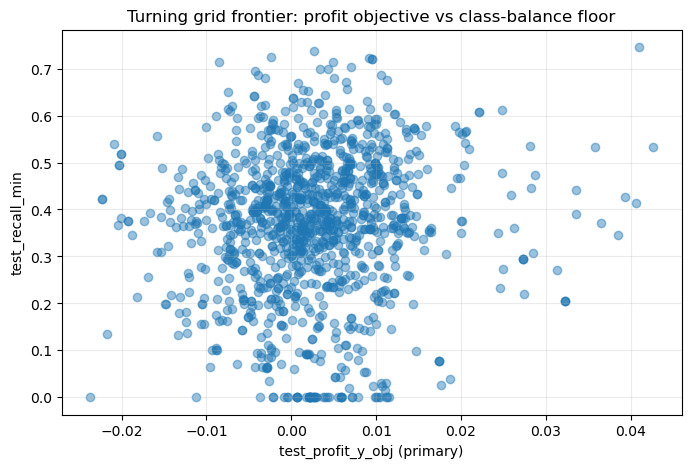

Best row summary:
  test_profit_y_obj: 0.042673854460693134
  test_profit_y: 0.0021326323020030113
  val_profit_y_obj: -0.007975465303421225
  val_profit_y: -0.0018163657403277903
  test_recall_up: 1.0
  test_recall_down: 0.5328798185941043
  test_recall_gap: 0.46712018140589573
  val_recall_up: 0.38461538461538464
  val_recall_down: 0.4609053497942387
  val_recall_gap: 0.07628996517885406
  mcc: 0.1643543155342268
  bal_acc: 0.7664399092970522
  label_up_move_pct: 0.04
  label_down_move_pct: 0.045
  label_cluster_gap_days: 5
  label_min_turn_gap_days: 4
  label_past_horizon_days: 7
  label_past_up_move_pct: 0.12
  label_past_down_move_pct: 0.06
  target_mode: segment_midpoint
  target_window_radius_days: nan
  target_window_distance_power: nan
  target_segment_center_power: 1.2
  target_segment_open_tail_direction_mode: endpoint_sign
  target_segment_open_tail_min_move_pct: 0.005
  target_min_weight: 0.03
  model_n_estimators: 300
  model_max_depth: 6
  model_learning_rate: 0.03
  thr

In [5]:
if df_results.empty:
    print("No results to display")
else:
    show_cols = [
        "test_profit_y_obj",
        "test_profit_y",
        "val_profit_y_obj",
        "val_profit_y",
        "test_move_weighted_acc",
        "test_top_move_acc",
        "test_direction_capture",
        "test_recall_up",
        "test_recall_down",
        "test_recall_gap",
        "val_recall_up",
        "val_recall_down",
        "val_recall_gap",
        "mcc",
        "bal_acc",
        "target_rows",
        "label_up_move_pct",
        "label_down_move_pct",
        "label_cluster_gap_days",
        "label_min_turn_gap_days",
        "label_past_horizon_days",
        "label_past_up_move_pct",
        "label_past_down_move_pct",
        "target_mode",
        "target_window_radius_days",
        "target_window_distance_power",
        "target_segment_center_power",
        "target_segment_open_tail_direction_mode",
        "target_segment_open_tail_min_move_pct",
        "target_min_weight",
        "model_n_estimators",
        "model_max_depth",
        "model_learning_rate",
        "threshold",
    ]
    show_cols = [c for c in show_cols if c in df_results.columns]

    print("Top 30 combos by test_profit_y_obj (PRIMARY)")
    display(df_results[show_cols].head(30))

    plt.figure(figsize=(8, 5))
    plt.scatter(df_results["test_profit_y_obj"], df_results["test_recall_min"], alpha=0.45)
    plt.xlabel("test_profit_y_obj (primary)")
    plt.ylabel("test_recall_min")
    plt.title("Turning grid frontier: profit objective vs class-balance floor")
    plt.grid(alpha=0.25)
    plt.show()

    best = df_results.iloc[0].to_dict()
    print("Best row summary:")
    for k in [
        "test_profit_y_obj", "test_profit_y", "val_profit_y_obj", "val_profit_y",
        "test_recall_up", "test_recall_down", "test_recall_gap",
        "val_recall_up", "val_recall_down", "val_recall_gap",
        "mcc", "bal_acc",
        "label_up_move_pct", "label_down_move_pct", "label_cluster_gap_days", "label_min_turn_gap_days",
        "label_past_horizon_days", "label_past_up_move_pct", "label_past_down_move_pct",
        "target_mode", "target_window_radius_days", "target_window_distance_power",
        "target_segment_center_power", "target_segment_open_tail_direction_mode", "target_segment_open_tail_min_move_pct",
        "target_min_weight",
        "model_n_estimators", "model_max_depth", "model_learning_rate", "threshold",
    ]:
        if k in best:
            print(f"  {k}: {best[k]}")
